# Project Title
### Data Engineering Capstone Project

#### Project Summary

The objective of this project was to utlize the skills learned throughout the course.  This is an open ended project to show what we have learned.  I've choosen to use the datasets projeced by Udacity to complete the project.  The main data set includes data on immigraiton to the United States and supplementary datasets included data on airport codes, U.S. city demographics, and temperature data. The use case for this analytics database is to find immigration patterns to the U.S.  
All data for the project was loaded into S3 after cleaning the datasets.  The project was completed within the Udacity workspace.

The files included in the workspace includes:

- config.cfg - the contains the configuration that allows the other modules the access AWS.
- utility.py - this module contains the functions for cleaning the data.
- sql_queries.py - this module drops, creates, and inserts the staging tables and fact and dimensional tables.
- create_cluster.py - this module creates the connection to AWS redshift and S3.
- create_tables.py - this module processes the sql_queries for staging, creating and inserting the tables.
- etl.py - this module reads the S3 data, processes the data using Spark, and writes processed data as a set of dimensional and fact tables back to S3.
- delete_cluster.py - deletes the cluster to avoid unnecessary charges.
- Capstone Project EDA.ipynb - Jupyter notebook used to gather, assess, and clean the data.
- Run.ipynb - Jupyter notebook used to run py files.
- Capstone Project Submision.ipynb - Jupyter notebook used to validate and show process of pulling data from S3 works and analysis can be done on data warehouse.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import os
import configparser
import json
from datetime import timedelta, datetime

from pyspark.sql import SparkSession

import utility
#import etl_functions
#import etl

import importlib
importlib.reload(utility)
from utility import visualize_missing_values
from utility import print_formatted_float
from utility import strip_all_columns, difference, sas_program_file_value_parser

### Load Configuration Data

In [2]:
# The AWS key id and password are configured in a configuration file "config.cfg"
config = configparser.ConfigParser()
config.read('config.cfg')

# Reads and saves the AWS access key information and saves them in a environment variable
os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['KEY']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['SECRET']

### Create a Spark Session

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_spark =spark.read.load('./data/sas_data')

### Step 1: Scope the Project and Gather Data

#### Scope 
The scope for the project is to integrate i94 immigration data, airport code data, world temperature data and US demographic data to set up a data warehouse with fact and dimension tables to be utilized for data analysis.

Data Sets (supplied by Udacity):

- i94 immigration data
- i94 port data (a subset of the immigration data manually created into JSON.) 
- airport code data
- US Demographics data
- world temperature data

Tools used:
 
- Python
- Juypter Notebooks
- AWS S3
- AWS Redshift

#### Describe and Gather Data 

- I94 Immigration Sample Data 
    - immigration_data_sample.csv 
        - csv  
            -This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. There's a sample file so you can take a look at the data in csv format before reading it all in. The sample dataset is in CSV format.
- I94 Port data 
    - i94port.json
        - json
            - Shows US Port of Entry city names and their corresponding codes. Source : I94_SAS_Labels_Descriptions.SAS
- World Temperature Data
    - world_temperature.csv
        - csv
            - This dataset contains temperature data of various cities from 1700's - 2013. This dataset came from Kaggle. 
- U.S. City Demographic Data
    - us-cities-demographics.csv
        - csv
            - This dataset contains population details of all US Cities and census-designated places includes gender & race informatoin. This data came from OpenSoft.
- Airport Code Table
    - airport-codes_csv.csv
        - csv
            - This is a simple table of airport codes and corresponding cities. 

***Load Datasets***

In [4]:
# Udacity provided datasets
# I94 Immigration Data Sample
immigration_df = pd.read_csv("./data/immigration_data_sample.csv")
# Airport Code Table
airport_codes_df = pd.read_csv("./data/airport-codes_csv.csv")
# U.S. City Demographic Data
#file_name = './data/us-cities-demographics.csv'
#demographics_df = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')
demographics_df = pd.read_csv("./data/us-cities-demographics.csv")
# Global Land Temperarture by City Data
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
worldtemp_df = pd.read_csv(fname)
worldtemp_df.to_csv('./data/world_temperature.csv', encoding='utf-8', index=False)
worldtemp_df.shape 

(8599212, 7)

### Step 2: Explore and Assess the Data
#### Explore the Data 

1. Use pandas for exploratory data analysis to get an overview of these datasets and clean the datasets.
2. Split the datasets to dimensional tables to change column names for better understanding.
3. Utilize PySpark on one of the SAS data sets to test ETL data pipeline logic.

#### Explore Immigration Data

In [5]:
# I94 Immigration subset of I94_SAS_Labels_Descriptions.SAS file manually extracted and saved as JSON
fname = './data/i94port.json'
i94port = json.load(open(fname))
print(i94port["NYC"])

dict_continent = {'AF':'Africa', 'AN':'Antarctica', 'AS':'Asia', 'EU':'Europe', 'NA':'North america', 'OC':'Oceania', 'SA':'South america' }
print(dict_continent["EU"])

NEW YORK, NY          
Europe


In [6]:
# Convert JSON Dictionaries to Dataframes
PoE_df = pd.DataFrame(list(i94port.items()), columns=['code', 'citystate'])
print('PoE_df = {}'.format(PoE_df.code.value_counts().shape[0]))

PoE_df = 660


In [7]:
immigration_df_shape = (df_spark.count(), len(df_spark.columns))
print(immigration_df_shape)

(3096313, 28)


In [8]:
immigration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
Unnamed: 0    1000 non-null int64
cicid         1000 non-null float64
i94yr         1000 non-null float64
i94mon        1000 non-null float64
i94cit        1000 non-null float64
i94res        1000 non-null float64
i94port       1000 non-null object
arrdate       1000 non-null float64
i94mode       1000 non-null float64
i94addr       941 non-null object
depdate       951 non-null float64
i94bir        1000 non-null float64
i94visa       1000 non-null float64
count         1000 non-null float64
dtadfile      1000 non-null int64
visapost      382 non-null object
occup         4 non-null object
entdepa       1000 non-null object
entdepd       954 non-null object
entdepu       0 non-null float64
matflag       954 non-null object
biryear       1000 non-null float64
dtaddto       1000 non-null object
gender        859 non-null object
insnum        35 non-null float64
airline       967 non

- From the above ***.info*** we can get a sense of missing data.

    - there are several issues with missing data seen above
       - US state (i94addr) has some missing, needs to verify
       - visapost has high number missing, needs to verify as this is the country the visa was issued.
       - occupation (occup) is basically empty, need to verify and see if data is needed.
       - all have arrival dates (arrdate) but not all have departure dates (depdate), so we can assume that some never left.
       - airline and fltno should be the same total but aren't, so some rows will need to be verifed.
       - gender is M/F/Null.  I94 file has gender type O.  Assumption is that Null is considered a third O gender.

In [9]:
# Statistics of all numeric columns in the dataframe
immigration_df.describe()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,arrdate,i94mode,depdate,i94bir,i94visa,count,dtadfile,entdepu,biryear,insnum,admnum
count,1.000000e+03,1.000000e+03,1000.0,1000.0,1000.000000,1000.00000,1000.000000,1000.000000,951.000000,1000.000000,1000.000000,1000.0,1.000000e+03,0.0,1000.000000,35.000000,1.000000e+03
mean,1.542097e+06,3.040461e+06,2016.0,4.0,302.928000,298.26200,20559.680000,1.078000,20575.037855,42.382000,1.859000,1.0,2.016042e+07,NaN,1973.618000,3826.857143,6.937237e+10
std,9.152879e+05,1.799818e+06,0.0,0.0,206.485285,202.12039,8.995027,0.485955,24.211234,17.903424,0.386353,0.0,4.951657e+01,NaN,17.903424,221.742583,2.338134e+10
min,1.092500e+04,1.320800e+04,2016.0,4.0,103.000000,103.00000,20545.000000,1.000000,20547.000000,1.000000,1.000000,1.0,2.016040e+07,NaN,1923.000000,3468.000000,0.000000e+00
25%,7.214422e+05,1.412170e+06,2016.0,4.0,135.000000,131.00000,20552.000000,1.000000,20561.000000,30.750000,2.000000,1.0,2.016041e+07,NaN,1961.000000,3668.000000,5.599301e+10
50%,1.494568e+06,2.941176e+06,2016.0,4.0,213.000000,213.00000,20560.000000,1.000000,20570.000000,42.000000,2.000000,1.0,2.016042e+07,NaN,1974.000000,3887.000000,5.931477e+10
75%,2.360901e+06,4.694151e+06,2016.0,4.0,438.000000,438.00000,20567.250000,1.000000,20580.000000,55.000000,2.000000,1.0,2.016042e+07,NaN,1985.250000,3943.000000,9.343623e+10
max,3.095749e+06,6.061994e+06,2016.0,4.0,746.000000,696.00000,20574.000000,9.000000,20715.000000,93.000000,3.000000,1.0,2.016080e+07,NaN,2015.000000,4686.000000,9.502151e+10


- From above ***.describe*** we can make assumptions,
    - age (i94bir) of the traveler so looking at the min / max we can get min/max age of visitors.
    - By looking at endtdepu has all null values, verified below with 100%. ***But already determined to be dropping this column.***
    - Looking at insum column there are only 35 entries, so NULL is no value, no data.  Assumption since below is at 96.5%.

In [10]:
(immigration_df.isnull().sum() / len(immigration_df))*100

Unnamed: 0      0.0
cicid           0.0
i94yr           0.0
i94mon          0.0
i94cit          0.0
i94res          0.0
i94port         0.0
arrdate         0.0
i94mode         0.0
i94addr         5.9
depdate         4.9
i94bir          0.0
i94visa         0.0
count           0.0
dtadfile        0.0
visapost       61.8
occup          99.6
entdepa         0.0
entdepd         4.6
entdepu       100.0
matflag         4.6
biryear         0.0
dtaddto         0.0
gender         14.1
insnum         96.5
airline         3.3
admnum          0.0
fltno           0.8
visatype        0.0
dtype: float64

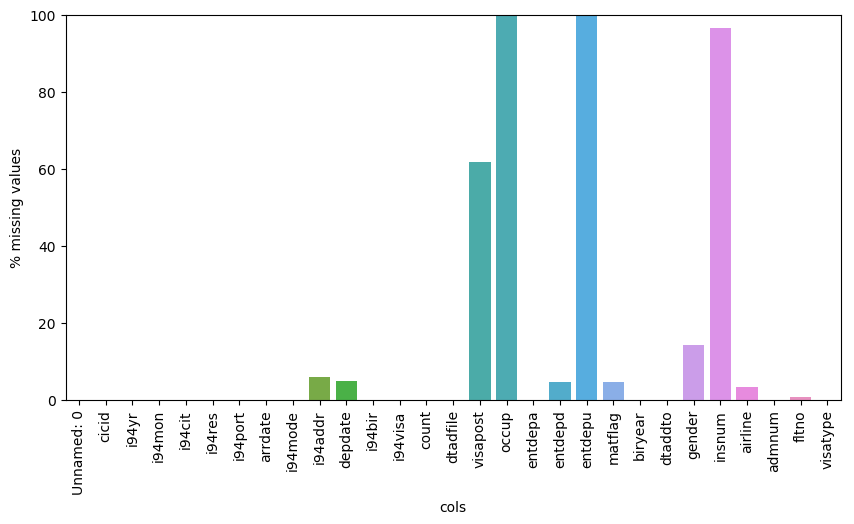

In [11]:
# lets visualize % missing values per immigration feature
visualize_missing_values(immigration_df)

- From information above we can see a high percentage (> 90%) of missing data in occup, entdepu, and insnum columns. 

In [12]:
immigration_df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


##### i94mode

In [13]:
# i94 mode - mode types
immigration_df['i94mode'].value_counts().head()

1.0    962
3.0     26
2.0     10
9.0      2
Name: i94mode, dtype: int64

- i94 mode - Other than 1, 2 & 3 can be removed

##### i94addr

In [14]:
# i94addr - City & State code
print(immigration_df[immigration_df.i94addr.isnull()].shape)
immigration_df['i94addr'].value_counts().head()

(59, 29)


FL    188
CA    163
NY    161
HI     53
TX     42
Name: i94addr, dtype: int64

##### i94bir

In [15]:
# i94bir - Age of visitor seems to be ok
print(immigration_df[immigration_df.i94bir.isnull()].shape)
immigration_df['i94bir'].value_counts().head()

(0, 29)


34.0    29
44.0    27
40.0    27
35.0    26
48.0    25
Name: i94bir, dtype: int64

##### visapost

In [16]:
# Country where a person got their visa
print(immigration_df[immigration_df.visapost.isnull()].shape)
immigration_df['visapost'].value_counts().head()

(618, 29)


MEX    28
BNS    21
BGT    14
SPL    14
SHG    13
Name: visapost, dtype: int64

##### occupation

In [17]:
# Occupation
print(immigration_df[immigration_df.occup.isnull()].shape)
immigration_df['occup'].value_counts().head()

(996, 29)


STU    2
OTH    1
PHA    1
Name: occup, dtype: int64

##### Checking entdpa, entdepd and entdepu

In [18]:
#print(type(temp))
cols = ['entdepa', 'entdepd', 'entdepu']
for c in cols:    
    print('#{}'.format(c))
    print(immigration_df[immigration_df[c].isnull()].shape)
    print(immigration_df[c].value_counts())

#entdepa
(0, 29)
G    757
O    140
A     34
Z     26
T     26
K      6
P      5
H      4
U      2
Name: entdepa, dtype: int64
#entdepd
(46, 29)
O    800
I     39
D     29
K     27
N     26
Q     18
R     10
W      3
J      1
L      1
Name: entdepd, dtype: int64
#entdepu
(1000, 29)
Series([], Name: entdepu, dtype: int64)


##### matflag

In [19]:
#match flag
print(immigration_df['matflag'].value_counts())
temp = immigration_df.copy()
#temp['matflag'] = temp.matflag.replace(np.nan,'None')
temp[temp['matflag'].isnull()].head()

M    954
Name: matflag, dtype: int64


,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
36,98732,216657.0,2016.0,4.0,696.0,696.0,FTL,20545.0,1.0,FL,...,NaN,NaN,1962.0,09302016,F,NaN,2D,9.251311e+10,00406,B2
79,2937355,5957654.0,2016.0,4.0,254.0,276.0,SAI,20556.0,1.0,GU,...,NaN,NaN,1996.0,05262016,M,3993.0,7C,4.511468e+10,03404,GMT
82,3052309,1435383.0,2016.0,4.0,574.0,206.0,BLA,20552.0,3.0,NE,...,NaN,NaN,1955.0,08082016,F,NaN,NaN,8.773307e+10,01788,B2
100,899737,1843262.0,2016.0,4.0,245.0,245.0,CHI,20554.0,1.0,IN,...,NaN,NaN,1956.0,10092016,F,NaN,AA,9.319157e+10,00186,B2
106,2068019,4231176.0,2016.0,4.0,586.0,586.0,NYC,20566.0,1.0,NJ,...,NaN,NaN,1948.0,10212016,NaN,NaN,AA,9.425292e+10,02179,B2


- Remove rows from ***matflag*** with mismatched arrivals/departures

##### dtaddto - the date person is admitted into the U.S.
- convert date format to a new column
- D/S is duration of stay is given to students
- This status should be for students only

In [20]:
print('Total Students Visa by D/S = {}'.format(immigration_df[immigration_df.dtaddto == 'D/S'].shape[0]))
temp = ['F1', 'F2', 'F3']
print('Total Students Visa by visatype = {}'.format(immigration_df[immigration_df.visatype.isin(temp)].shape[0]))
immigration_df[immigration_df.dtaddto == 'D/S'].head()

Total Students Visa by D/S = 13
Total Students Visa by visatype = 13


,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
70,1773904,3599863.0,2016.0,4.0,582.0,582.0,HOU,20563.0,1.0,TX,...,NaN,M,1974.0,D/S,F,NaN,WN,9.399116e+10,02831,F1
238,262355,513953.0,2016.0,4.0,268.0,268.0,LOS,20547.0,1.0,CA,...,NaN,M,1997.0,D/S,M,NaN,BR,9.268561e+10,00012,F1
274,1082384,2209111.0,2016.0,4.0,268.0,268.0,SFR,20556.0,1.0,MA,...,NaN,M,1990.0,D/S,F,NaN,UA,9.332991e+10,00872,F1
337,2749532,5514177.0,2016.0,4.0,343.0,343.0,HOU,20573.0,1.0,TX,...,NaN,NaN,2013.0,D/S,M,NaN,EK,9.488994e+10,00211,F2
415,692967,1400880.0,2016.0,4.0,213.0,213.0,NEW,20552.0,1.0,NJ,...,NaN,NaN,2014.0,D/S,M,NaN,AI,7.258104e+08,191,F2


In [21]:
# Format and add new column
temp = immigration_df[['dtaddto']].copy()
temp['allowed_until'] = pd.to_datetime(temp['dtaddto'], format="%m%d%Y", errors='coerce')
temp.head()

,dtaddto,allowed_until
0,07202016,2016-07-20
1,10222016,2016-10-22
2,07052016,2016-07-05
3,10272016,2016-10-27
4,07042016,2016-07-04


##### gender

In [22]:
immigration_df.gender.value_counts()

M    471
F    386
X      2
Name: gender, dtype: int64

- gender X denotes people who do not identify as male or female
- per the US Visa regulations, three genders are supported M/F/O.  So X can be converted to O.

In [23]:
temp = ['M','F','O']
print(immigration_df[~immigration_df.gender.isin(temp)].shape)
print(immigration_df[immigration_df.gender.isnull()].shape)
immigration_df[(~immigration_df.gender.isin(temp)) & (immigration_df.gender.notnull())]

(143, 29)
(141, 29)


,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
680,2909398,5902022.0,2016.0,4.0,112.0,112.0,HHW,20559.0,9.0,NaN,...,NaN,NaN,1961.0,07142016,X,3517.0,NaN,4.711430e+10,NaN,WT
879,3015485,6046172.0,2016.0,4.0,254.0,276.0,SAI,20569.0,1.0,NaN,...,NaN,M,2005.0,06082016,X,3980.0,OZ,4.616520e+10,NaN,GMT


##### fltno

In [24]:
# fltno
print(immigration_df[immigration_df.fltno.isnull()].shape)
immigration_df['fltno'].value_counts().head()

(8, 29)


LAND     19
00001    12
00008    12
00102     7
00003     7
Name: fltno, dtype: int64

- drop NULLs

##### airline

In [25]:
# airline
print(immigration_df[immigration_df.airline.isnull()].shape)
immigration_df['airline'].value_counts().head()

(33, 29)


AA    109
UA     84
DL     77
BA     53
LH     45
Name: airline, dtype: int64

##### visatype

In [26]:
# Visatype
print(immigration_df[immigration_df.visatype.isnull()].shape)
immigration_df['visatype'].value_counts().head()

(0, 29)


WT     443
B2     356
WB      91
B1      61
GMT     27
Name: visatype, dtype: int64

- ***visatype*** GMT is not valid so can be deleted

- Verify if when visatype =  WT that the visapost is always NULL

In [27]:
immigration_df[immigration_df.visatype =='WT'].head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT
7,112205,232708.0,2016.0,4.0,113.0,135.0,NYC,20546.0,1.0,NY,...,NaN,M,1983.0,06302016,F,NaN,BA,5.547449e+10,00117,WT
8,2577162,5227851.0,2016.0,4.0,131.0,131.0,CHI,20572.0,1.0,IL,...,NaN,M,1977.0,07262016,NaN,NaN,LX,5.941342e+10,00008,WT


***Assessment: I94***

***Only remaining columns will be kept for further analysis: i94cit, i94res, i94port, arrdate, i94mode, depdate, i94bir, i94visa, biryear, gender, airline, admnum, fltno, visatype***

***Assessing other datasets that can possibly be joined with i94 dataset***

#### Point of Entry Data
##### PoE_df - Point of Entry
- mapped with immigration_df(i94port)
- split columns city,state to separate columns city and state

In [28]:
PoE_df.head()

,code,citystate
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [29]:
test = PoE_df.copy()
test["citystate"] = test["citystate"].map(str.strip)

#test['citystate'].str.split(r'\s*,\s*(?=[A-Z])', expand=True)
test[['city', 'state']] = test['citystate'].str.rsplit(",",n=1, expand=True)
test['city'] = test['city'].str.strip()
test['state'] = test['state'].str.strip()

# Strip all columns
test = strip_all_columns(test)
#for col in test.columns:
#    test[col] = test[col].str.strip()
    
test.head()

,code,citystate,city,state
0,ALC,"ALCAN, AK",ALCAN,AK
1,ANC,"ANCHORAGE, AK",ANCHORAGE,AK
2,BAR,"BAKER AAF - BAKER ISLAND, AK",BAKER AAF - BAKER ISLAND,AK
3,DAC,"DALTONS CACHE, AK",DALTONS CACHE,AK
4,PIZ,"DEW STATION PT LAY DEW, AK",DEW STATION PT LAY DEW,AK


- correct the state column

In [30]:
# Last CSV column is suppose to be STATE code
# #ARPT is Airport abbrev. Replace that with blank string.
test[test.citystate.str.contains('ARPT')].head(2)

,code,citystate,city,state
25,ROG,"ROGERS ARPT, AR",ROGERS ARPT,AR
65,ASE,"ASPEN, CO #ARPT",ASPEN,CO #ARPT


In [31]:
# #INT is International. Replace that with blank string
test[test.citystate.str.contains('#INT')].head(2)

,code,citystate,city,state
478,BLI,"BELLINGHAM, WASHINGTON #INTL",BELLINGHAM,WASHINGTON #INTL


In [32]:
# second row : Last word has to be a state code for WASHINGTON its WA
test[test.citystate.str.contains('WASHINGTON')].head(2)

,code,citystate,city,state
76,WAS,"WASHINGTON, DC",WASHINGTON,DC
478,BLI,"BELLINGHAM, WASHINGTON #INTL",BELLINGHAM,WASHINGTON #INTL


In [33]:
# Replace codes such as (BPS) and other column values coded within parenthesis with blank string
test[ (test.citystate.str.contains(r'\)$') ) & (test.citystate.notnull()) & (~test.citystate.str.lower().str.contains('no port code'))]

,code,citystate,city,state
24,LIA,"LITTLE ROCK, AR (BPS)",LITTLE ROCK,AR (BPS)
52,SLS,"SALINAS, CA (BPS)",SALINAS,CA (BPS)
57,SLI,"SAN LUIS OBISPO, CA (BPS)",SAN LUIS OBISPO,CA (BPS)
61,STO,"STOCKTON, CA (BPS)",STOCKTON,CA (BPS)
141,LAK,"LAKE CHARLES, LA (BPS)",LAKE CHARLES,LA (BPS)
174,RGM,"RANGELEY, ME (BPS)",RANGELEY,ME (BPS)
235,EUR,"EUREKA, MT (BPS)",EUREKA,MT (BPS)
296,ALA,"ALAMAGORDO, NM (BPS)",ALAMAGORDO,NM (BPS)
302,DNM,"DEMING, NM (BPS)",DEMING,NM (BPS)
304,LOB,"LORDSBURG, NM (BPS)",LORDSBURG,NM (BPS)


In [34]:
print('Null = ',test[test.state.isnull()].shape)
print('No Port = ',test[test.citystate.str.lower().str.contains('no port code') ].shape)
print('Collapsed = ',test[test.citystate.str.lower().str.contains('collapsed') ].shape)
print('Unidentified = ',test[test.citystate.str.lower().str.contains('unident') ].shape)
print('Unknown = ',test[test.citystate.str.lower().str.contains('unknown') ].shape)

#print(test[test.citystate.str.lower().str.contains('no port code') ].shape)
#test[test.citystate.str.lower().str.contains('no port code') ].head()

Null =  (75, 4)
No Port =  (60, 4)
Collapsed =  (12, 4)
Unidentified =  (1, 4)
Unknown =  (2, 4)


In [35]:
test[test.citystate.str.lower().str.contains('no port code') ].head()

,code,citystate,city,state
576,CHN,No PORT Code (CHN),No PORT Code (CHN),None
601,PHF,No PORT Code (PHF),No PORT Code (PHF),None
602,DRV,No PORT Code (DRV),No PORT Code (DRV),None
603,FTB,No PORT Code (FTB),No PORT Code (FTB),None
604,GAC,No PORT Code (GAC),No PORT Code (GAC),None


In [36]:
test[test.citystate.str.lower().str.contains('collapsed') ].head()

,code,citystate,city,state
198,GTF,"Collapsed into INT, MN",Collapsed into INT,MN
199,INL,"Collapsed into INT, MN",Collapsed into INT,MN
591,FRG,Collapsed (FOK) 06/15,Collapsed (FOK) 06/15,None
592,HRL,Collapsed (HLG) 06/15,Collapsed (HLG) 06/15,None
593,ISP,Collapsed (FOK) 06/15,Collapsed (FOK) 06/15,None


In [37]:
test[test.state.isnull()].head()

,code,citystate,city,state
516,XXX,NOT REPORTED/UNKNOWN,NOT REPORTED/UNKNOWN,None
517,888,UNIDENTIFED AIR / SEAPORT,UNIDENTIFED AIR / SEAPORT,None
518,UNK,UNKNOWN POE,UNKNOWN POE,None
575,ZZZ,MEXICO Land (Banco de Mexico),MEXICO Land (Banco de Mexico),None
576,CHN,No PORT Code (CHN),No PORT Code (CHN),None


- delete the rows having values as NULL/ UNKNOWN / UNIDENTIFIED / COLLAPSED

#### Airport Code Data

In [38]:
airport_codes_df_shape = (df_spark.count(), len(df_spark.columns))
print(airport_codes_df_shape)

(3096313, 28)


In [39]:
airport_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [40]:
airport_codes_df.describe()

,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


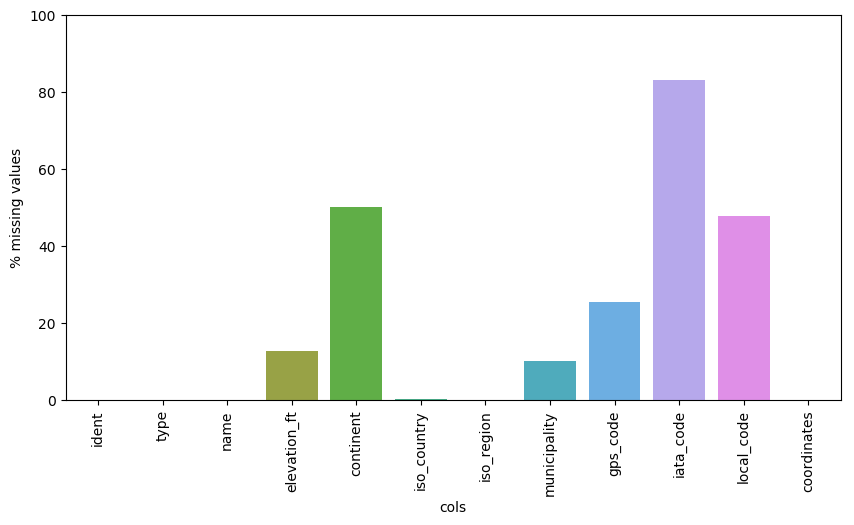

In [41]:
# lets visualize % missing values per immigration feature
visualize_missing_values(airport_codes_df)

- Gives us an idea about missing data but let's keep digging.

In [42]:
airport_codes_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [43]:
airport_codes_df.describe()
#airport_codes_df['elevation_ft'].describe()

,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


In [44]:
airport_codes_df.iata_code.value_counts().head()

0      80
OHE     3
PRI     3
PHL     2
KOH     2
Name: iata_code, dtype: int64

In [45]:
airport_codes_df.local_code.value_counts().head()

LAN    5
AMA    5
AGI    4
HOB    4
SJT    4
Name: local_code, dtype: int64

In [46]:
airport_codes_df[airport_codes_df.local_code=='AMA']

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
10688,AMF,small_airport,Ama Airport,145.0,OC,PG,PG-ESW,NaN,AYAA,AMF,AMA,"141.67, -4.10111111111"
11309,AR-0546,small_airport,La Amalia,328.0,SA,AR,AR-B,Roberts,NaN,NaN,AMA,"-62.01656, -35.10042"
26076,KAMA,large_airport,Rick Husband Amarillo International Airport,3607.0,NaN,US,US-TX,Amarillo,KAMA,AMA,AMA,"-101.706001, 35.219398"
34559,MX-0345,small_airport,Amatlan de Jora Airport,4757.0,NaN,MX,MX-NAY,La Yesca,NaN,NaN,AMA,"-104.128434, 21.393753"
44234,SK-262,small_airport,La Amalia Airport,113.0,SA,CO,CO-MAG,CiÃ©naga,NaN,NaN,AMA,"-74.145833, 10.860833"


- Looks like local codes are being used within country and some countries have same local codes 'AMA' as in Ama Airport and Rick Husband above.

In [47]:
# List countries
print('Total Countries = {}'.format(airport_codes_df.iso_country.value_counts().shape[0]))

# There are 7 continents in the world. Below null is for US
print('How many airports are in each continents ? ')
airport_codes_df.continent.value_counts()

Total Countries = 243
How many airports are in each continents ? 


EU    7840
SA    7709
AS    5350
AF    3362
OC    3067
AN      28
Name: continent, dtype: int64

In [48]:
airport_codes_df.iso_country.value_counts().head()

US    22757
BR     4334
CA     2784
AU     1963
KR     1376
Name: iso_country, dtype: int64

In [49]:
# Finding countries with no names and grouping them to know which continent they belong to
# 1. Getting the list of iso_country is null
# 2. Viewing the dataframe
# 3. Grouping it by continent and counting
# 4. Only africa continent appears
airport_codes_df[airport_codes_df['iso_country'].isna()].groupby('continent')['continent'].count()

continent
AF    247
Name: continent, dtype: int64

In [50]:
airport_codes_df[airport_codes_df['iso_country'].isna()].head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
21422,FYAA,small_airport,Ai-Ais Airport,2000.0,AF,NaN,NA-KU,Ai-Ais,FYAA,AIW,NaN,"17.5966, -27.995"
21423,FYAB,small_airport,Aroab B Airport,3235.0,AF,NaN,NA-KA,Aroab,FYAB,NaN,NaN,"19.633100509643555, -26.776100158691406"
21424,FYAK,small_airport,Aussenkehr Airport,970.0,AF,NaN,NA-KA,Aussenkehr,FYAK,NaN,NaN,"17.4645, -28.4587"
21425,FYAM,small_airport,Aminuis Airstrip,4012.0,AF,NaN,NA-OH,Aminuis,FYAM,NaN,NaN,"19.351699829101562, -23.655799865722656"
21426,FYAR,medium_airport,Arandis Airport,1905.0,AF,NaN,NA-ER,Arandis,FYAR,ADI,NaN,"14.979999542236328, -22.462200164794922"


In [51]:
print('Total Airports : {}'.format(airport_codes_df.shape[0]))
print('Airports with IATA code : {}'.format(airport_codes_df.iata_code.value_counts().shape[0]))
cond1 = airport_codes_df.iso_country =='US'
print('Total US Airports : {}'.format(airport_codes_df[cond1].shape[0]))
print('Total Non-US Airports : {}'.format(airport_codes_df[~cond1].shape[0]))
cond2 = airport_codes_df['iata_code'].notnull()
print('Total US Airports with IATA code : {}'.format(airport_codes_df[cond1 & cond2].shape[0]))
print('Total US Airports without IATA code : {}'.format(airport_codes_df[ cond1 & ~cond2].shape[0]))
cond3 = airport_codes_df['local_code'].isnull()
print('Total US Airports where IATA code is null and local code is null : {}'.format(airport_codes_df[ cond1 & ~cond2 & cond3].shape[0]))
print('Total US Airports where IATA code is null and local code has value : {}'.format(airport_codes_df[ cond1 & ~cond2 & ~cond3].shape[0]))
cond4 = airport_codes_df['continent'].isnull()
print('Total US Airports where continent is null : {}'.format(airport_codes_df[cond1 & cond4].shape[0]))
print('Total US Airports where continent is not null : {}'.format(airport_codes_df[cond1 & ~cond4].shape[0]))

Total Airports : 55075
Airports with IATA code : 9042
Total US Airports : 22757
Total Non-US Airports : 32318
Total US Airports with IATA code : 2019
Total US Airports without IATA code : 20738
Total US Airports where IATA code is null and local code is null : 1471
Total US Airports where IATA code is null and local code has value : 19267
Total US Airports where continent is null : 22756
Total US Airports where continent is not null : 1


- All airports without IATA Codes can be elimiated because all commercial and passenger airports must use an IATA code.

In [52]:
# Continent should not be NULL 
airport_codes_df[cond1 & ~cond4].head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
37387,OI05,heliport,Dana Heliport,625.0,AS,US,US-OH,Toledo,OI05,NaN,OI05,"-83.6465988159, 41.65589904789999"


In [53]:
# Non-US countries where continent column is not updated.
cond1 = airport_codes_df.continent.isnull()
cond2 = airport_codes_df.iso_country=='US'
print('Non-US countries where continent column is not updated = {}'.format(airport_codes_df[cond1 & ~cond2].shape[0]))
airport_codes_df[cond1 & ~cond2].head()

Non-US countries where continent column is not updated = 4963


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
174,02PR,small_airport,Cuylers Airport,15.0,NaN,PR,PR-U-A,Vega Baja,02PR,NaN,02PR,"-66.36689758300781, 18.45330047607422"
1360,12PR,heliport,Villamil-304 Ponce De Leon Heliport,148.0,NaN,PR,PR-U-A,San Juan,12PR,NaN,12PR,"-66.05699920654297, 18.42259979248047"
1484,14PR,heliport,Emp. Coco Beach Golf Club LLC Heliport,11.0,NaN,PR,PR-U-A,Rio Grande,14PR,NaN,14PR,"-65.798751, 18.407301"
2230,1PR3,heliport,San Patricio Heliport,157.0,NaN,PR,PR-U-A,Guaynabo,1PR3,NaN,1PR3,"-66.10600280761719, 18.406099319458008"
2898,28PR,heliport,La Concepcion Hospital Heliport,120.0,NaN,PR,PR-U-A,San German,28PR,NaN,28PR,"-67.03939819335938, 18.108699798583984"


In [54]:
airport_codes_df.type.value_counts()

small_airport     33965
heliport          11287
medium_airport     4550
closed             3606
seaplane_base      1016
large_airport       627
balloonport          24
Name: type, dtype: int64

In [55]:
print('Is null = ',airport_codes_df[airport_codes_df.iata_code.isnull()].shape[0] )
print('Is not null = ',airport_codes_df[~airport_codes_df.iata_code.isnull()].shape[0] )

Is null =  45886
Is not null =  9189


In [56]:
# scheduled/passenger airports will have IATA codes
test = airport_codes_df[~airport_codes_df.iata_code.isnull()].copy()
test.type.value_counts()

small_airport     4238
medium_airport    3859
large_airport      602
closed             279
seaplane_base      143
heliport            68
Name: type, dtype: int64

 - Can eliminate airports 'seaplane_base', 'heliport', and 'closed' they won't have immigration facilities.

In [57]:
temp = ['small_airport', 'medium_airport', 'large_airport']
test = test[test['type'].isin(temp)].copy()
print('Current Total Airports = {}'.format(test.shape[0]))
print('How many airports in US = {}'.format(test[test.iso_country =='US'].shape[0]))
test.type.value_counts()

Current Total Airports = 8699
How many airports in US = 1865


small_airport     4238
medium_airport    3859
large_airport      602
Name: type, dtype: int64

In [58]:
test = test[test.iso_country =='US'].copy()
print('Total Airports = {}'.format(test.shape[0]))
test.head()

Total Airports = 1865


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
440,07FA,small_airport,Ocean Reef Club Airport,8.0,NaN,US,US-FL,Key Largo,07FA,OCA,07FA,"-80.274803161621, 25.325399398804"
594,0AK,small_airport,Pilot Station Airport,305.0,NaN,US,US-AK,Pilot Station,NaN,PQS,0AK,"-162.899994, 61.934601"
673,0CO2,small_airport,Crested Butte Airpark,8980.0,NaN,US,US-CO,Crested Butte,0CO2,CSE,0CO2,"-106.928341, 38.851918"
1088,0TE7,small_airport,LBJ Ranch Airport,1515.0,NaN,US,US-TX,Johnson City,0TE7,JCY,0TE7,"-98.62249755859999, 30.251800537100003"
1402,13MA,small_airport,Metropolitan Airport,418.0,NaN,US,US-MA,Palmer,13MA,PMX,13MA,"-72.31140136719999, 42.223300933800004"


In [59]:
# Splitting the region code to separate column
test['state'] = test.iso_region.str.slice(start=3)
test.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,state
440,07FA,small_airport,Ocean Reef Club Airport,8.0,NaN,US,US-FL,Key Largo,07FA,OCA,07FA,"-80.274803161621, 25.325399398804",FL
594,0AK,small_airport,Pilot Station Airport,305.0,NaN,US,US-AK,Pilot Station,NaN,PQS,0AK,"-162.899994, 61.934601",AK
673,0CO2,small_airport,Crested Butte Airpark,8980.0,NaN,US,US-CO,Crested Butte,0CO2,CSE,0CO2,"-106.928341, 38.851918",CO
1088,0TE7,small_airport,LBJ Ranch Airport,1515.0,NaN,US,US-TX,Johnson City,0TE7,JCY,0TE7,"-98.62249755859999, 30.251800537100003",TX
1402,13MA,small_airport,Metropolitan Airport,418.0,NaN,US,US-MA,Palmer,13MA,PMX,13MA,"-72.31140136719999, 42.223300933800004",MA


In [60]:
print('Total States = {}'.format(test.state.value_counts().shape[0]))
test.state.value_counts()

Total States = 51


AK    267
CA    141
TX    113
FL     75
WA     48
MI     47
AZ     45
WI     42
IA     41
NY     41
OK     41
PA     39
IL     38
CO     37
GA     37
OR     36
IN     36
KS     36
MN     35
OH     35
NC     33
VA     31
NE     31
SC     31
NM     30
NV     29
AR     29
UT     28
WY     28
MO     28
AL     28
MS     27
MT     26
TN     25
LA     22
MA     20
HI     20
ME     19
SD     18
KY     17
MD     17
ID     17
NJ     16
ND     15
WV     13
NH     12
VT      7
CT      7
RI      6
DE      3
DC      2
Name: state, dtype: int64

In [61]:
airport_codes_df.coordinates.str.split(", ",expand=True).head()

,0,1
0,-74.93360137939453,40.07080078125
1,-101.473911,38.704022
2,-151.695999146,59.94919968
3,-86.77030181884766,34.86479949951172
4,-91.254898,35.6087


In [62]:
# Remove duplicate airport rows
airport_codes_df[airport_codes_df.name.str.contains('uplicate')].head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
2331,1W5,closed,[Duplicate] Hoby Wolf Airport,600.0,NaN,US,US-MD,Eldersburg,1W5,NaN,1W5,"-76.9274978638, 39.4079017639"
4191,3C5,closed,[Duplicate] Wheeler Airport,720.0,NaN,US,US-IN,Knox,3C5,NaN,3C5,"-86.60700225830001, 41.1898002625"
10769,AR-0006,closed,[Duplicate] Brigadier Hector Ruiz Airport,228.0,SA,AR,AR-B,Coronel Suarez,NaN,CSZ,NaN,"-61.8833007812, -37.4333000183"
11564,AU-0051,closed,[Duplicate] Baralaba,340.0,OC,AU,AU-QLD,Baralaba,YBAB,NaN,NaN,"149.843166, -24.19357"
11637,AU-BCK,closed,[Duplicate] Bolwarra Airport,NaN,OC,AU,AU-QLD,Bolwarra,NaN,BCK,NaN,"144.169006348, -17.388299942"


#### U.S. Demographics Data

In [63]:
demographics_df_shape = (df_spark.count(), len(df_spark.columns))
print(demographics_df_shape)

(3096313, 28)


In [64]:
demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 1 columns):
City;State;Median Age;Male Population;Female Population;Total Population;Number of Veterans;Foreign-born;Average Household Size;State Code;Race;Count    2891 non-null object
dtypes: object(1)
memory usage: 22.7+ KB


In [65]:
demographics_df= pd.read_csv('./data/us-cities-demographics.csv', delimiter=';')

In [66]:
demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


- Need to check for NULL values in Male Population, Female Population, Total Population, Number of Veterans, Foreigh-born, and Average Household Size

In [67]:
demographics_df.describe()

,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,Count
count,2891.000000,2.888000e+03,2.888000e+03,2.891000e+03,2878.000000,2.878000e+03,2875.000000,2.891000e+03
mean,35.494881,9.732843e+04,1.017696e+05,1.989668e+05,9367.832523,4.065360e+04,2.742543,4.896377e+04
std,4.401617,2.162999e+05,2.315646e+05,4.475559e+05,13211.219924,1.557491e+05,0.433291,1.443856e+05
min,22.900000,2.928100e+04,2.734800e+04,6.321500e+04,416.000000,8.610000e+02,2.000000,9.800000e+01
25%,32.800000,3.928900e+04,4.122700e+04,8.042900e+04,3739.000000,9.224000e+03,2.430000,3.435000e+03
50%,35.300000,5.234100e+04,5.380900e+04,1.067820e+05,5397.000000,1.882200e+04,2.650000,1.378000e+04
75%,38.000000,8.664175e+04,8.960400e+04,1.752320e+05,9368.000000,3.397175e+04,2.950000,5.444700e+04
max,70.500000,4.081698e+06,4.468707e+06,8.550405e+06,156961.000000,3.212500e+06,4.980000,3.835726e+06


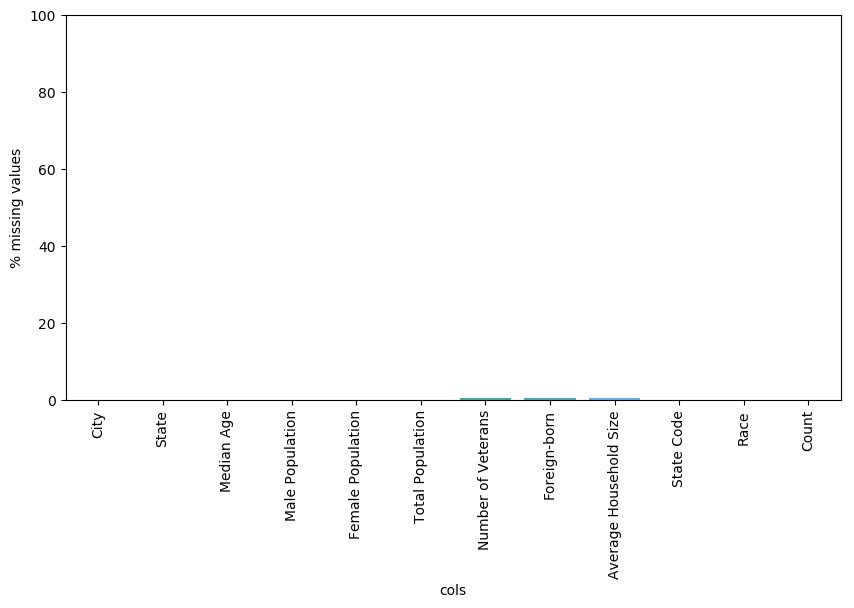

In [68]:
# lets visualize % missing values per immigration feature
visualize_missing_values(demographics_df)

In [69]:
demographics_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


- Convert to integers: 'Male Population', 'Female Population', 'Number of Veterans', 'Foreign-born', 'Total Population', 'Count'

In [70]:
demographics_df1 = demographics_df.copy()

# Convert floats to ints
cols_to_convert_float_to_int = ['Male Population', 'Female Population', 'Number of Veterans', 'Foreign-born', 'Total Population', 'Count']

for col in cols_to_convert_float_to_int:
    demographics_df1[col] = demographics_df1[col].replace(np.nan, 0)
    demographics_df1[col] = demographics_df1[col].astype(int)

In [71]:
print('Total US States = {}'.format(demographics_df1.State.value_counts().shape[0]))

Total US States = 49


In [72]:
cond1 = demographics_df1['State'] =='Alabama' 
cond2 = demographics_df1['City'] == 'Hoover'
demographics_df1[cond1 & cond2]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
960,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Black or African-American,18191
1410,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Hispanic or Latino,3430
1541,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,White,61869


In [73]:
demographics_df1.Race.value_counts()

Hispanic or Latino                   596
White                                589
Black or African-American            584
Asian                                583
American Indian and Alaska Native    539
Name: Race, dtype: int64

- looks to have some missing date; race has American Indian and Alaska Native 
- race counts don't add up to Male Population + Female Population. (Manually checked for validation that Male population + Female population add upto Total population but the race count don't add up.)
- should separate into seperate dataframes to better access
        - demog_df - state, city, state code, male population, female population, total population, veterans, foreign-born
        - race_df - state, city, state code, race_counts

In [74]:
# Check to see if M + F = TP for all rows
demographics_df1[~(demographics_df1['Male Population'] + demographics_df1['Female Population'] == demographics_df1['Total Population'])]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
333,The Villages,Florida,70.5,0,0,72590,15231,4034,NaN,FL,Hispanic or Latino,1066
449,The Villages,Florida,70.5,0,0,72590,15231,4034,NaN,FL,Black or African-American,331
1437,The Villages,Florida,70.5,0,0,72590,15231,4034,NaN,FL,White,72211


- Remove the above rows

In [75]:
# Removing above row
demographics_df1 = demographics_df1[(demographics_df1['Male Population'] + demographics_df1['Female Population'] == demographics_df1['Total Population'])].copy()

In [76]:
# Check for duplicates of city, state, state code and race
demographics_df1[demographics_df1[['City', 'State', 'State Code', 'Race']].duplicated()]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count


In [77]:
# Split dataframes based on race
demog_df = demographics_df1[['State', 'City', 'Median Age', 'State Code', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born']]
demog_df = demog_df.drop_duplicates()

race_df = demographics_df1[['State', 'City', 'State Code', 'Race', 'Count']]
race_df = race_df.drop_duplicates()

In [78]:
print(' Total rows in {} = {}'.format('demog_df', demog_df.shape[0]))
print(' Total rows in {} = {}'.format('race_df', race_df.shape[0]))

 Total rows in demog_df = 595
 Total rows in race_df = 2888


In [79]:
demographics_df1.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [80]:
# Verifying specified rows exists in both dataframes
cond1 = demog_df['State'] =='Alabama' 
cond2 = demog_df['City'] == 'Hoover'
demog_df[cond1 & cond2]

,State,City,Median Age,State Code,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born
2,Alabama,Hoover,38.5,AL,38040,46799,84839,4819,8229


In [81]:
cond1 = race_df['State'] =='Alabama' 
cond2 = race_df['City'] == 'Hoover'
race_df[cond1 & cond2]

,State,City,State Code,Race,Count
2,Alabama,Hoover,AL,Asian,4759
960,Alabama,Hoover,AL,Black or African-American,18191
1410,Alabama,Hoover,AL,Hispanic or Latino,3430
1541,Alabama,Hoover,AL,White,61869


In [82]:
# Unmelting to convert Race rows to columns
race_df = race_df.set_index(['State','City','State Code', 'Race']).Count.unstack().reset_index()
race_df.columns.name = None
#test.head()
race_df[race_df.State =='Alabama'].head()

,State,City,State Code,American Indian and Alaska Native,Asian,Black or African-American,Hispanic or Latino,White
0,Alabama,Birmingham,AL,1319.0,1500.0,157985.0,8940.0,51728.0
1,Alabama,Dothan,AL,656.0,1175.0,23243.0,1704.0,43516.0
2,Alabama,Hoover,AL,NaN,4759.0,18191.0,3430.0,61869.0
3,Alabama,Huntsville,AL,1755.0,6566.0,61561.0,10887.0,121904.0
4,Alabama,Mobile,AL,2816.0,5518.0,96397.0,5229.0,93755.0


- Looks like after converting race rows to columns the Race Counts have changed to float and need to be converted to int

In [83]:
race_df.columns

Index(['State', 'City', 'State Code', 'American Indian and Alaska Native',
       'Asian', 'Black or African-American', 'Hispanic or Latino', 'White'],
      dtype='object')

In [84]:
# Convert floats to ints
cols_to_convert_float_to_int = ['American Indian and Alaska Native','Asian', 'Black or African-American', 'Hispanic or Latino', 'White']

for col in cols_to_convert_float_to_int:
    race_df[col] = race_df[col].replace(np.nan, 0)
    race_df[col] = race_df[col].astype(int)

In [85]:
print('Total demog_df = ',demog_df.shape[0])
print('Total race_df = ',race_df.shape[0])

Total demog_df =  595
Total race_df =  595


In [86]:
race_df.head()

,State,City,State Code,American Indian and Alaska Native,Asian,Black or African-American,Hispanic or Latino,White
0,Alabama,Birmingham,AL,1319,1500,157985,8940,51728
1,Alabama,Dothan,AL,656,1175,23243,1704,43516
2,Alabama,Hoover,AL,0,4759,18191,3430,61869
3,Alabama,Huntsville,AL,1755,6566,61561,10887,121904
4,Alabama,Mobile,AL,2816,5518,96397,5229,93755


***Americans and Foreign-born population***

In [87]:
american_df = demog_df[['State Code', 'Male Population', 'Female Population', 'Total Population', 'Foreign-born']]
totbystate_df = american_df.groupby(['State Code']).sum().reset_index()
print(totbystate_df.shape)
totbystate_df.sort_values(by=['Total Population'], ascending=False).head()  

(49, 5)


,State Code,Male Population,Female Population,Total Population,Foreign-born
4,CA,12278281,12544179,24822460,7448257
44,TX,7063571,7236412,14299983,2942164
34,NY,4692055,5123571,9815626,3438081
9,FL,3236773,3487375,6724148,1684897
14,IL,2218541,2343771,4562312,941735


In [88]:
totbystate_df['americans'] = totbystate_df['Total Population'] - totbystate_df['Foreign-born']
# FP = Foreign population
totbystate_df['FP'] = (totbystate_df['Foreign-born']/totbystate_df['Total Population'])*100
# AP = American population
totbystate_df['AP'] = ((totbystate_df['Total Population'] - totbystate_df['Foreign-born'])/totbystate_df['Total Population'])*100
# TP = Total population
totbystate_df['TP'] = (totbystate_df['FP'] + totbystate_df['AP'])
totbystate_df.sort_values(by=['FP'], ascending=False).head()

,State Code,Male Population,Female Population,Total Population,Foreign-born,americans,FP,AP,TP
34,NY,4692055,5123571,9815626,3438081,6377545,35.026610,64.973390,100.0
31,NJ,705736,723172,1428908,477028,951880,33.384095,66.615905,100.0
4,CA,12278281,12544179,24822460,7448257,17374203,30.006119,69.993881,100.0
11,HI,176807,175959,352766,101312,251454,28.719321,71.280679,100.0
19,MA,975713,1039744,2015457,520597,1494860,25.830221,74.169779,100.0


***Race percentage***

In [89]:
sum_cols = ['American Indian and Alaska Native', 'Asian', 'Black or African-American', 'Hispanic or Latino', 'White']
totbystate_df = race_df.groupby(['State Code'])[sum_cols].sum().reset_index()
print(totbystate_df.shape)
totbystate_df.head()

(49, 6)


,State Code,American Indian and Alaska Native,Asian,Black or African-American,Hispanic or Latino,White
0,AK,36339,36825,23107,27261,212696
1,AL,8084,28769,521068,39313,498920
2,AR,9381,22062,149608,77813,384733
3,AZ,129708,229183,296222,1508157,3591611
4,CA,401386,4543730,2047009,9856464,14905129


In [90]:
totbystate_df['Total Population'] = totbystate_df[sum_cols].sum(axis=1)

totbystate_df['aian'] = (totbystate_df['American Indian and Alaska Native']/totbystate_df['Total Population'])*100
totbystate_df['asian'] = (totbystate_df['Asian']/totbystate_df['Total Population'])*100
totbystate_df['baa'] = (totbystate_df['Black or African-American']/totbystate_df['Total Population'])*100
totbystate_df['hl'] = (totbystate_df['Hispanic or Latino']/totbystate_df['Total Population'])*100
totbystate_df['white'] = (totbystate_df['White']/totbystate_df['Total Population'])*100
sum_cols = ['aian', 'asian', 'baa', 'hl', 'white']
totbystate_df['TP'] = totbystate_df[sum_cols].sum(axis=1)

totbystate_df.sort_values(by=['Total Population'], ascending=False).head()

,State Code,American Indian and Alaska Native,Asian,Black or African-American,Hispanic or Latino,White,Total Population,aian,asian,baa,hl,white,TP
4,CA,401386,4543730,2047009,9856464,14905129,31753718,1.264060,14.309285,6.446518,31.040346,46.939791,100.0
44,TX,154497,924552,2130242,6311431,10508923,20029645,0.771342,4.615918,10.635446,31.510449,52.466846,100.0
34,NY,112816,1373373,2605008,2730185,4555686,11377068,0.991609,12.071414,22.897007,23.997264,40.042707,100.0
9,FL,46759,264933,1652288,1940956,4685933,8590869,0.544287,3.083891,19.233072,22.593244,54.545506,100.0
3,AZ,129708,229183,296222,1508157,3591611,5754881,2.253878,3.982411,5.147318,26.206571,62.409822,100.0


#### World Temperature

In [91]:
worldtemp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [92]:
worldtemp_df['dt'] = pd.to_datetime(worldtemp_df.dt)

In [93]:
worldtemp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [94]:
# Rounding temperature to decimals=3 as 2.1010000000000004
worldtemp_df['AverageTemperature'] = worldtemp_df['AverageTemperature'].round(decimals=3)

In [95]:
tempcopy_df = worldtemp_df.copy()

In [96]:
# Removing missing temperatures
print(tempcopy_df[(tempcopy_df.AverageTemperature.isnull()) & (tempcopy_df.AverageTemperatureUncertainty.isnull())].shape[0])
tempcopy_df = tempcopy_df[~((tempcopy_df.AverageTemperature.isnull()) & (tempcopy_df.AverageTemperatureUncertainty.isnull()))]

364130


In [97]:
tempcopy_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [98]:
print('Total Rows = ',tempcopy_df.shape[0])
print('Total Countries = ',tempcopy_df.Country.unique().shape[0])
print('Total Cities = ',tempcopy_df.City.unique().shape[0])
tempcopy_df.Country.unique()

Total Rows =  8235082
Total Countries =  159
Total Cities =  3448


array(['Denmark', 'Turkey', 'Kazakhstan', 'China', 'Spain', 'Germany',
       'Nigeria', 'Iran', 'Russia', 'Canada', "Côte D'Ivoire",
       'United Kingdom', 'Saudi Arabia', 'Japan', 'United States', 'India',
       'Benin', 'United Arab Emirates', 'Mexico', 'Venezuela', 'Ghana',
       'Ethiopia', 'Australia', 'Yemen', 'Indonesia', 'Morocco',
       'Pakistan', 'France', 'Libya', 'Burma', 'Brazil', 'South Africa',
       'Syria', 'Egypt', 'Algeria', 'Netherlands', 'Malaysia', 'Portugal',
       'Ecuador', 'Italy', 'Uzbekistan', 'Philippines', 'Madagascar',
       'Chile', 'Belgium', 'El Salvador', 'Romania', 'Peru', 'Colombia',
       'Tanzania', 'Tunisia', 'Turkmenistan', 'Israel', 'Eritrea',
       'Paraguay', 'Greece', 'New Zealand', 'Vietnam', 'Cameroon', 'Iraq',
       'Afghanistan', 'Argentina', 'Azerbaijan', 'Moldova', 'Mali',
       'Congo (Democratic Republic Of The)', 'Thailand',
       'Central African Republic', 'Bosnia And Herzegovina', 'Bangladesh',
       'Switzerland'

In [99]:
df_UStemp = tempcopy_df[tempcopy_df.Country=='United States'].copy()
print('Total Rows = ',df_UStemp.shape[0])
print('Total Cities = ',df_UStemp.City.unique().shape[0])

Total Rows =  661524
Total Cities =  248


In [100]:
# Looking for duplicates
tempcopy_df[((tempcopy_df[['dt', 'City', 'Country']].duplicated()) & (~tempcopy_df.City.isin(['Arlington'])) ) ].head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
485395,1775-04-01,9.290,1.692,Aurora,United States,40.99N,87.34W
485396,1775-05-01,17.177,2.099,Aurora,United States,40.99N,87.34W
485400,1775-09-01,17.002,2.282,Aurora,United States,40.99N,87.34W
485401,1775-10-01,12.015,1.910,Aurora,United States,40.99N,87.34W
485402,1775-11-01,6.864,3.195,Aurora,United States,40.99N,87.34W


In [101]:
tempcopy_df[tempcopy_df[['dt', 'City', 'Country']].duplicated()]['City'].unique()

array(['Arlington', 'Aurora', 'Columbus', 'Depok', 'Glendale', 'Haicheng',
       'Haikou', 'Jining', 'Luoyang', 'Pasadena', 'Peoria', 'Richmond',
       'Rongcheng', 'Springfield', 'Suzhou', 'Taman', 'Yichun', 'Yingcheng'], dtype=object)

In [102]:
tempcopy_df.query("dt=='1820-01-01' and City=='Arlington' and Country=='United States'")

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
401036,1820-01-01,3.293,3.278,Arlington,United States,32.95N,96.70W
404275,1820-01-01,-3.022,7.662,Arlington,United States,39.38N,76.99W


- Looking at the above locations(lats & lngs), temperature is recorded in different part of city or different weather stations may be.
- But looking at Arlington AvgTemperature +3 to -3.
- Proceeding to eliminating the duplicates(ie., second locations in the same city)

In [103]:
tempcopy_df2 = tempcopy_df.drop_duplicates(['dt', 'City', 'Country'],keep= 'first')
tempcopy_df2.shape

(8190783, 7)

In [104]:
tempcopy_df2.query("dt=='1820-01-01' and City=='Arlington' and Country=='United States'")

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
401036,1820-01-01,3.293,3.278,Arlington,United States,32.95N,96.70W


In [105]:
# Getting TopN Max/Min Temperatures
tempcopy_df3 = tempcopy_df2.sort_values(by=['Country', 'City', 'AverageTemperature'],  ascending=False)
tempcopy_df3 = tempcopy_df3.groupby(['Country', 'City']).tail(5).reset_index(drop=True)
tempcopy_df3.query("City=='Arlington' and Country=='United States'")

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
1670,1774-01-01,-3.323,6.555,Arlington,United States,39.38N,76.99W
1671,1763-01-01,-3.342,2.226,Arlington,United States,39.38N,76.99W
1672,1761-01-01,-3.736,6.418,Arlington,United States,39.38N,76.99W
1673,1792-01-01,-3.904,4.811,Arlington,United States,39.38N,76.99W
1674,1752-01-01,-4.318,2.217,Arlington,United States,39.38N,76.99W


In [106]:
tempcopy_df2.shape[0]

8190783

In [107]:
# Min/Max dates
test1 = (tempcopy_df2.assign(dt=tempcopy_df2['dt'])
       .groupby(['Country'])['dt'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('Date'))
test1 = test1.reset_index()

In [108]:
test1.head()

,Country,DateMin,DateMax
0,Afghanistan,1833-01-01,2013-08-01
1,Albania,1743-11-01,2013-08-01
2,Algeria,1753-01-01,2013-08-01
3,Angola,1856-01-01,2013-08-01
4,Argentina,1832-01-01,2013-08-01


- Start dates vary, when analyzing all dates should be brought to same date
- End dates are in 2013 and i94 is 2016 so can't co-relate these two datasets, so can relate to US Demographics. Race & Temperature, Temperature & Household income

In [109]:
test1.min()
test1['DateMin'].min()

Timestamp('1743-11-01 00:00:00')

In [110]:
temp = {'city': df_UStemp['City'], 'year': df_UStemp['dt'].dt.year, 'yb10': (df_UStemp['dt'].dt.year/10).astype(int), 'AverageTemperature': df_UStemp['AverageTemperature']}
temp =  pd.DataFrame(data=temp)
temp[temp.city=='Abilene'].head(50)

,city,year,yb10,AverageTemperature
47555,Abilene,1820,182,2.101
47556,Abilene,1820,182,6.926
47557,Abilene,1820,182,10.767
47558,Abilene,1820,182,17.989
47559,Abilene,1820,182,21.809
47560,Abilene,1820,182,25.682
47561,Abilene,1820,182,26.268
47562,Abilene,1820,182,25.048
47563,Abilene,1820,182,22.435
47564,Abilene,1820,182,15.830


In [111]:
df_USt10yr = temp.groupby(['city', 'yb10'])['AverageTemperature'].agg(['mean', 'min', 'max']).reset_index().copy()

In [112]:
df_USt10yr.head()

,city,yb10,mean,min,max
0,Abilene,182,16.624283,2.101,28.631
1,Abilene,183,16.381756,2.196,29.641
2,Abilene,184,16.447308,2.857,28.728
3,Abilene,185,16.497983,-0.061,29.203
4,Abilene,186,16.905758,3.052,29.376


- above could be used for reporting trends of temperatures

In [113]:
# Min/Max average temperatures
test2 = (tempcopy_df2.assign(dt=tempcopy_df2['AverageTemperature'])
       .groupby(['Country', 'City'])['AverageTemperature'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('Temp'))
test2 = test2.reset_index()

In [114]:
test2[test2.City =='Madrid']

,Country,City,TempMin,TempMax
2857,Spain,Madrid,-0.918,24.771


In [115]:
df_UStemp[df_UStemp.City.str.lower().str.contains('chi')].head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
1543348,1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W
1543353,1744-04-01,8.766,2.357,Chicago,United States,42.59N,87.27W
1543354,1744-05-01,11.605,2.102,Chicago,United States,42.59N,87.27W
1543355,1744-06-01,17.965,1.989,Chicago,United States,42.59N,87.27W
1543356,1744-07-01,21.680,1.786,Chicago,United States,42.59N,87.27W


In [116]:
df_miami = tempcopy_df[tempcopy_df.City=='Miami']
df_chicago = tempcopy_df[tempcopy_df.City=='Chicago']

In [117]:
def create_city_df(df):
    temp = {'year': df['dt'].dt.year, 'AverageTemperature': df['AverageTemperature']}
    test3 =  pd.DataFrame(data=temp)
    test3['AvgTemp'] = test3.groupby(['year'])['AverageTemperature'].transform(lambda x: x.mean())
    return test3[['year', 'AvgTemp']].drop_duplicates()

create_city_df(df_miami).tail(5)

,year,AvgTemp
4805278,2009,23.900833
4805290,2010,22.751250
4805302,2011,24.234833
4805314,2012,23.922667
4805326,2013,24.440111


In [118]:
create_city_df(df_chicago).tail(5)

,year,AvgTemp
1546530,2009,10.298333
1546542,2010,11.815917
1546554,2011,11.214250
1546566,2012,12.821250
1546578,2013,11.586889


In [119]:
temp = {'dt': tempcopy_df['dt'], 'year': tempcopy_df['dt'].dt.year, 'AverageTemperature': tempcopy_df['AverageTemperature']}
test3 =  pd.DataFrame(data=temp)

In [120]:
# calculate the average temperature for each year, I group by by Year and then find the average tempearature
test3['AvgTemp'] = test3.groupby(['year'])['AverageTemperature'].transform(lambda x: x.mean())

In [121]:
test3[['year', 'AvgTemp']].drop_duplicates().tail(30)

,year,AvgTemp
2882,1984,17.750915
2894,1985,17.760221
2906,1986,17.878246
2918,1987,18.093333
2930,1988,18.121302
2942,1989,18.139926
2954,1990,18.438358
2966,1991,18.111252
2978,1992,18.015379
2990,1993,17.942710


#### Cleaning Steps
Document steps necessary to clean the data

***Create copies of dateframes to cleanse***

In [122]:
# Create copies of dataframe
immigration_df1 = immigration_df.copy()
PoE_df1 = PoE_df.copy()
airport_codes_df1 = airport_codes_df.copy()
demographics_df1 = demographics_df.copy()
worldtemp_df1 = worldtemp_df.copy()

# Running strip() on all string columns
immigration_df1 = strip_all_columns(immigration_df1).copy()
PoE_df1 =strip_all_columns(PoE_df).copy()
worldtemp_df1 = strip_all_columns(worldtemp_df1).copy()

#### Immigration data cleaning steps

***Quality***
- Delete incompleted & invalid rows
    - matflag is null
    - visatype GMT
    - i94mode other than 1, 2, 3 can be removed.
    - incomplete: gender in null
    - removed rows having invalid CoC & CoR\
    - remove Non-US Port of entry data
    - update genter X to O
 
***Tideness***

- Keep only these columns
    i94cit, i94res, i94port, i94addr, arrdate, i94mode, depdate, i94addr, i94bir, i94visa, biryear, gender, airline, admnum, fltno, visatype
- Convert float to string(i94cit, i94res, arrdate, i94mode, depdate, i94bir, i94visa, biryear, admnum
- Convert codes to descriptive column names for below columns
    - i94mode - How they arrived - arrival_mode
    - i94visa - Purpose of visit - visit_purpose
- Convert date formats
    - SAS encoded date (arrdate & depdate)
- Rename columns; i94bir=age, i94cit=CoC, i94res=CoR, i94port=PoE, i94addr=arrival_state, arrdate=arrival_dt, depdate=departure_dt
- Drop final set columns i94mode, i94visa, arrdate, depdate, dtadfile, dtaddto

##### Immigration Data Cleaning: immigration_df1

- Delete incomplete and invalid rows

##### ***Define***

Delete below rows:

- invalid: matflag is null
- invalid: visatype GMT
- invalid: i94mode other and 1, 2, 3 can be removed
- incomplete: gender is null

Drop initial unused columns

##### ***Define***

Keeping only these columns; i94cit, i94res, i94 addr, i94port, arrdate, i94mode, i94addr, depadate, i94bir, i94visa, biryear, gender, airline, admnum, fltno, visatype

***Code***

In [123]:
# matflag is null
immigration_df1 = immigration_df1[immigration_df1['matflag'].notnull()]

# visatype GMT  
temp = immigration_df1.visatype.tolist()
immigration_df1 = immigration_df1[immigration_df1.visatype.isin(temp)]

# i94mode other than 1 2 3
temp = [1, 2, 3]
immigration_df1 = immigration_df1[immigration_df1.i94mode.isin(temp)]

# gender is null
immigration_df1 = immigration_df1[immigration_df1.gender.notnull()]

***Test***

In [124]:
print('Original : immigration_df = {}'.format(immigration_df.shape[0]))
print('After    : immigration_df1= {}'.format(immigration_df1.shape[0]))

print('matflag is null = ',immigration_df1[immigration_df1['matflag'].isnull()].shape[0])

# visatype GMT  
temp = immigration_df1.visatype.tolist()
print('visatype GMT = ',immigration_df1[~immigration_df1.visatype.isin(temp)].shape[0])

# i94mode other than 1 2 3
temp = [1, 2, 3]
print('i94mode other than (1 2 3) = ',immigration_df1[~immigration_df1.i94mode.isin(temp)].shape[0])

# Gender is null
print('Gender is null = ',immigration_df1[immigration_df1.gender.isnull()].shape[0])

Original : immigration_df = 1000
After    : immigration_df1= 816
matflag is null =  0
visatype GMT =  0
i94mode other than (1 2 3) =  0
Gender is null =  0


In [125]:
# Drop visatype GMT since it is an invalid visatype
immigration_df1.drop(immigration_df1.index[immigration_df1['visatype'] == 'GMT'], inplace = True)

In [126]:
# Dropping column named Unnamed
print(immigration_df1.columns)
print(immigration_df1.columns.str.match('Unnamed'))

Index(['Unnamed: 0', 'cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port',
       'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa',
       'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd',
       'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum',
       'airline', 'admnum', 'fltno', 'visatype'],
      dtype='object')
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [127]:
# This technique can be used for columns having sequence numbers
immigration_df1 = immigration_df1.loc[:, ~immigration_df1.columns.str.match('Unnamed')]
print(immigration_df1.columns)

Index(['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate',
       'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count',
       'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu',
       'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline',
       'admnum', 'fltno', 'visatype'],
      dtype='object')


In [128]:
# Only below columns are used for analysis
keep_columns = ['i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'depdate', 'i94addr'
                , 'i94bir', 'i94visa', 'biryear', 'gender', 'airline', 'admnum', 'fltno', 'visatype']

In [129]:
drop_cols = difference(keep_columns, immigration_df1.columns.tolist())
print(drop_cols)

['cicid', 'i94yr', 'i94mon', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'dtaddto', 'insnum']


In [130]:
immigration_df1.drop(drop_cols, inplace = True, axis = 1)

***Test***

In [131]:
print(immigration_df1.columns)

Index(['i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr',
       'depdate', 'i94bir', 'i94visa', 'biryear', 'gender', 'airline',
       'admnum', 'fltno', 'visatype'],
      dtype='object')


#### Immigration_df1: Update gender from X to O

***Define***

I94 allows three categories for gender M/F/O but the i94 data has X for the third gender.  Those rows will be updated from X to O.

***Code***

In [132]:
immigration_df1['gender'] = immigration_df1['gender'].str.replace('X', 'O')

***Test***

In [133]:
immigration_df1[immigration_df1.gender == 'O']

,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,biryear,gender,airline,admnum,fltno,visatype


#### Immigration_df1: Convert float to string

***Define***

Convert these columns(i94cit, i94res, arrdate, i94mode, depdate, i94bir, i94visa, biryear, admnum)

***Code***

In [134]:
immigration_df1.head()

,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,biryear,gender,airline,admnum,fltno,visatype
0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1955.0,F,JL,5.658267e+10,00782,WT
1,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1990.0,M,*GA,9.436200e+10,XBLNG,B2
2,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1940.0,M,LH,5.578047e+10,00464,WT
3,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1991.0,M,QR,9.478970e+10,00739,B2
4,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1997.0,F,NaN,4.232257e+10,LAND,WT


In [135]:
# Convert floats to ints
cols_to_convert_float_to_string = ['i94cit', 'i94res', 'arrdate', 'i94mode', 'depdate', 'i94bir'
                                , 'i94visa', 'biryear', 'admnum']
for col in cols_to_convert_float_to_string:
    immigration_df1[col] = immigration_df1[col].replace(np.nan, 0)
    immigration_df1[col] = immigration_df1[col].astype(int)
    immigration_df1[col] = immigration_df1[col].astype(str)

***Test***

In [136]:
immigration_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 0 to 999
Data columns (total 15 columns):
i94cit      792 non-null object
i94res      792 non-null object
i94port     792 non-null object
arrdate     792 non-null object
i94mode     792 non-null object
i94addr     757 non-null object
depdate     792 non-null object
i94bir      792 non-null object
i94visa     792 non-null object
biryear     792 non-null object
gender      792 non-null object
airline     766 non-null object
admnum      792 non-null object
fltno       788 non-null object
visatype    792 non-null object
dtypes: object(15)
memory usage: 99.0+ KB


In [137]:
immigration_df1.head()

,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,biryear,gender,airline,admnum,fltno,visatype
0,209,209,HHW,20566,1,HI,20573,61,2,1955,F,JL,56582674633,00782,WT
1,582,582,MCA,20567,1,TX,20568,26,2,1990,M,*GA,94361995930,XBLNG,B2
2,148,112,OGG,20551,1,FL,20571,76,2,1940,M,LH,55780468433,00464,WT
3,297,297,LOS,20572,1,CA,20581,25,2,1991,M,QR,94789696030,00739,B2
4,111,111,CHM,20550,3,NY,20553,19,2,1997,F,NaN,42322572633,LAND,WT


#### Immigration_df1: Changing codes in columns to meaningful names

***Define***

Updated columns will be,

- i94mode = arrival_mode since this is how they arrived
    - 1 = Air
    - 2 = Sea
    - 3 = Land
    - 9 = Not Reported
- i94visa = visit_purpose since this is the purpose of their visit
    - 1 = Business
    - 2 = Pleasure
    - 3 = Student

***Code***

In [138]:
# Mapping : Codes to descriptive
i94mode = {'1' : 'Air', '2' : 'Sea', '3' : 'Land', '9' : 'Not reported'}
immigration_df1['arrival_mode'] = immigration_df1['i94mode'].map(i94mode)

i94visa = {'1' : 'Business', '2' : 'Pleasure', '3' : 'Student' }
immigration_df1['visit_purpose'] = immigration_df1['i94visa'].map(i94visa)

***Test***

In [139]:
immigration_df1.head()

,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,biryear,gender,airline,admnum,fltno,visatype,arrival_mode,visit_purpose
0,209,209,HHW,20566,1,HI,20573,61,2,1955,F,JL,56582674633,00782,WT,Air,Pleasure
1,582,582,MCA,20567,1,TX,20568,26,2,1990,M,*GA,94361995930,XBLNG,B2,Air,Pleasure
2,148,112,OGG,20551,1,FL,20571,76,2,1940,M,LH,55780468433,00464,WT,Air,Pleasure
3,297,297,LOS,20572,1,CA,20581,25,2,1991,M,QR,94789696030,00739,B2,Air,Pleasure
4,111,111,CHM,20550,3,NY,20553,19,2,1997,F,NaN,42322572633,LAND,WT,Land,Pleasure


#### Immigration_df1: Convert SAS date (arrdate & depdate) and dtaddto to date format

***Define***

Convert date formats

- SAS encoded date (arrdate & depdate)
- For column dtaddto from mmddyyy to yyyy-mm-dd

***Code***

In [140]:
# Conversion of SAS encoded dates(arrdate & depdate)
# Converting arrdate, depdate to int as we had converted that to string earlier
from datetime import timedelta
immigration_df1['arrival_dt'] = pd.datetime(1960, 1, 1) + pd.to_timedelta(immigration_df1.arrdate.astype(int), unit="D")
immigration_df1['departure_dt'] = pd.datetime(1960, 1, 1) + pd.to_timedelta(immigration_df1.depdate.astype(int), unit="D")

###immigration_df1['DaysinUS'] = immigration_df1[immigration_df1.departure_dt != '1960-01-01']['departure_dt'].sub(immigration_df1['arrival_dt'], axis=0).dt.days

#1960-01-01 is a constant added in the top. Now change all dates 1960-01-01 to np.NaN as those are not real dates
immigration_df1.loc[immigration_df1.departure_dt == '1960-01-01', 'departure_dt'] = np.NaN

***Test***

In [141]:
immigration_df1.head()

,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,biryear,gender,airline,admnum,fltno,visatype,arrival_mode,visit_purpose,arrival_dt,departure_dt
0,209,209,HHW,20566,1,HI,20573,61,2,1955,F,JL,56582674633,00782,WT,Air,Pleasure,2016-04-22,2016-04-29
1,582,582,MCA,20567,1,TX,20568,26,2,1990,M,*GA,94361995930,XBLNG,B2,Air,Pleasure,2016-04-23,2016-04-24
2,148,112,OGG,20551,1,FL,20571,76,2,1940,M,LH,55780468433,00464,WT,Air,Pleasure,2016-04-07,2016-04-27
3,297,297,LOS,20572,1,CA,20581,25,2,1991,M,QR,94789696030,00739,B2,Air,Pleasure,2016-04-28,2016-05-07
4,111,111,CHM,20550,3,NY,20553,19,2,1997,F,NaN,42322572633,LAND,WT,Land,Pleasure,2016-04-06,2016-04-09


#### Immigration_df1: Rename columns

***Define***

Rename columns (i94bir=age, i94cit=Cit, i94res=Res, i94port=PoE)

***Code***

In [142]:
immigration_df1.rename(columns={"i94bir": "age", "i94addr":"arrival_state", "i94cit":"CoC", "i94res":"CoR", "i94port":"PoE"}, inplace=True)

***Test***

In [143]:
immigration_df1.head()

,CoC,CoR,PoE,arrdate,i94mode,arrival_state,depdate,age,i94visa,biryear,gender,airline,admnum,fltno,visatype,arrival_mode,visit_purpose,arrival_dt,departure_dt
0,209,209,HHW,20566,1,HI,20573,61,2,1955,F,JL,56582674633,00782,WT,Air,Pleasure,2016-04-22,2016-04-29
1,582,582,MCA,20567,1,TX,20568,26,2,1990,M,*GA,94361995930,XBLNG,B2,Air,Pleasure,2016-04-23,2016-04-24
2,148,112,OGG,20551,1,FL,20571,76,2,1940,M,LH,55780468433,00464,WT,Air,Pleasure,2016-04-07,2016-04-27
3,297,297,LOS,20572,1,CA,20581,25,2,1991,M,QR,94789696030,00739,B2,Air,Pleasure,2016-04-28,2016-05-07
4,111,111,CHM,20550,3,NY,20553,19,2,1997,F,NaN,42322572633,LAND,WT,Land,Pleasure,2016-04-06,2016-04-09


#### Immigration_df1: Drop final set of columns

***Define***

Drop i94mode, i94visa, i94addr, arrdate, depdate

***Code***

In [144]:
drop_cols2 = ['i94mode', 'i94visa',  'arrdate', 'depdate']
immigration_df1.drop(drop_cols2, inplace = True, axis = 1)
print(drop_cols2)

['i94mode', 'i94visa', 'arrdate', 'depdate']


***Test***

In [145]:
immigration_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 0 to 999
Data columns (total 15 columns):
CoC              792 non-null object
CoR              792 non-null object
PoE              792 non-null object
arrival_state    757 non-null object
age              792 non-null object
biryear          792 non-null object
gender           792 non-null object
airline          766 non-null object
admnum           792 non-null object
fltno            788 non-null object
visatype         792 non-null object
arrival_mode     792 non-null object
visit_purpose    792 non-null object
arrival_dt       792 non-null datetime64[ns]
departure_dt     789 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(13)
memory usage: 99.0+ KB


In [146]:
immigration_df1.head()

,CoC,CoR,PoE,arrival_state,age,biryear,gender,airline,admnum,fltno,visatype,arrival_mode,visit_purpose,arrival_dt,departure_dt
0,209,209,HHW,HI,61,1955,F,JL,56582674633,00782,WT,Air,Pleasure,2016-04-22,2016-04-29
1,582,582,MCA,TX,26,1990,M,*GA,94361995930,XBLNG,B2,Air,Pleasure,2016-04-23,2016-04-24
2,148,112,OGG,FL,76,1940,M,LH,55780468433,00464,WT,Air,Pleasure,2016-04-07,2016-04-27
3,297,297,LOS,CA,25,1991,M,QR,94789696030,00739,B2,Air,Pleasure,2016-04-28,2016-05-07
4,111,111,CHM,NY,19,1997,F,NaN,42322572633,LAND,WT,Land,Pleasure,2016-04-06,2016-04-09


#### PoE data cleaning steps

***Quality***

- PoE_df : Correct incorrect state code values
- PoE_df : Remove invalid rows & ports outside US

     a) state with null values
     
     b) Rows with strings "no port", "collapsed", "unknown", "unidentified"
     
     c) Ports outside U.S      
     
***Tideness***

- PoE_df : Split one column into two (citystate) into (city, state)

#### PoE_df1: Split one column into to two columns

***Define***

Split column citystate into two separate columns city and state

***Code***

In [147]:
PoE_df1["citystate"] = PoE_df1["citystate"].map(str.strip)

PoE_df1[['city', 'state']] = PoE_df1['citystate'].str.rsplit(",",n=1, expand=True)
PoE_df1 = strip_all_columns(PoE_df1)

***Test***

In [148]:
PoE_df1.head()

,code,citystate,city,state
0,ALC,"ALCAN, AK",ALCAN,AK
1,ANC,"ANCHORAGE, AK",ANCHORAGE,AK
2,BAR,"BAKER AAF - BAKER ISLAND, AK",BAKER AAF - BAKER ISLAND,AK
3,DAC,"DALTONS CACHE, AK",DALTONS CACHE,AK
4,PIZ,"DEW STATION PT LAY DEW, AK",DEW STATION PT LAY DEW,AK


#### PoE_df1: Remove invalid rows and ports outside US

***Define***

Remove invalid rows

- state with NULLs
- rows with strings 'no port', 'collapsed', 'unknown', 'unidentified'
- ports outside of US

***Code***

In [149]:
PoE_df1 = strip_all_columns(PoE_df1).copy()

In [150]:
PoE_df1 = PoE_df1[PoE_df1.state.notnull()]

cond1 = PoE_df1.city.str.lower().str.contains('collapsed')
PoE_df1 = PoE_df1[~cond1]

cond1 = PoE_df1.city.str.lower().str.contains('no port')
PoE_df1 = PoE_df1[~cond1]

cond1 = PoE_df1.city.str.lower().str.contains('unknown')
PoE_df1 = PoE_df1[~cond1]

cond1 = PoE_df1.city.str.lower().str.contains('identifi')
PoE_df1 = PoE_df1[~cond1]

PoE_df1 = PoE_df1[PoE_df1.state.str.len() == 2]

***Test***

In [151]:
print('State is null = {}'.format(PoE_df1[PoE_df1.state.isnull()].shape[0]))
cond1 = PoE_df1.city.str.lower().str.contains('collapsed')
print('Port of entry collapsed = {}'.format(PoE_df1[cond1].shape[0]))
cond1 = PoE_df1.city.str.lower().str.contains('no port')
print('City has No port  = {}'.format(PoE_df1[cond1].shape[0]))
cond1 = PoE_df1.city.str.lower().str.contains('unknown')
print('City has string unknown  = {}'.format(PoE_df1[cond1].shape[0]))
cond1 = PoE_df1.city.str.lower().str.contains('identifi')
print('City has string unidentified  = {}'.format(PoE_df1[cond1].shape[0]))
print('US State code > CHAR(2) = {}'.format(PoE_df1[PoE_df1.state.str.len() > 2].shape[0]))

print('Before : df_USPoE = {}'.format(PoE_df.shape[0]))
print('After  : df_USPoE1= {}'.format(PoE_df1.shape[0]))

State is null = 0
Port of entry collapsed = 0
City has No port  = 0
City has string unknown  = 0
City has string unidentified  = 0
US State code > CHAR(2) = 0
Before : df_USPoE = 660
After  : df_USPoE1= 509


In [152]:
print('Unique States = ',len(PoE_df1[PoE_df1.state.str.len() == 2]['state'].unique()))

Unique States =  55


In [153]:
df1 = PoE_df1[['code', 'state']]
lst = set(df1.state.unique()) - set(df1.code.unique())

print('All US states & territories = {}'.format(df1.shape[0]))
print('Total PoE in US = {}'.format(PoE_df1.state.unique().shape[0]))
print('Non US entries = {}'.format(lst))
#print('States which are not in df_USPoE1 = ',difference(PoE_df1.code.tolist(), PoE_df1.state.tolist()))

All US states & territories = 509
Total PoE in US = 55
Non US entries = {'DC', 'LA', 'MS', 'IL', 'KS', 'AZ', 'VI', 'IA', 'OH', 'UT', 'AL', 'NC', 'AK', 'CT', 'MX', 'WA', 'MA', 'NV', 'MI', 'ID', 'WY', 'FL', 'AR', 'SD', 'CA', 'PA', 'OK', 'IN', 'NJ', 'RI', 'WV', 'NE', 'OR', 'NY', 'DE', 'GA', 'SC', 'CO', 'HI', 'MT', 'MN', 'ND', 'GU', 'NH', 'TX', 'KY', 'ME', 'MD', 'MO', 'PR', 'NM', 'WI', 'VT', 'TN', 'VA'}


In [154]:
PoE_df1.head()

,code,citystate,city,state
0,ALC,"ALCAN, AK",ALCAN,AK
1,ANC,"ANCHORAGE, AK",ANCHORAGE,AK
2,BAR,"BAKER AAF - BAKER ISLAND, AK",BAKER AAF - BAKER ISLAND,AK
3,DAC,"DALTONS CACHE, AK",DALTONS CACHE,AK
4,PIZ,"DEW STATION PT LAY DEW, AK",DEW STATION PT LAY DEW,AK


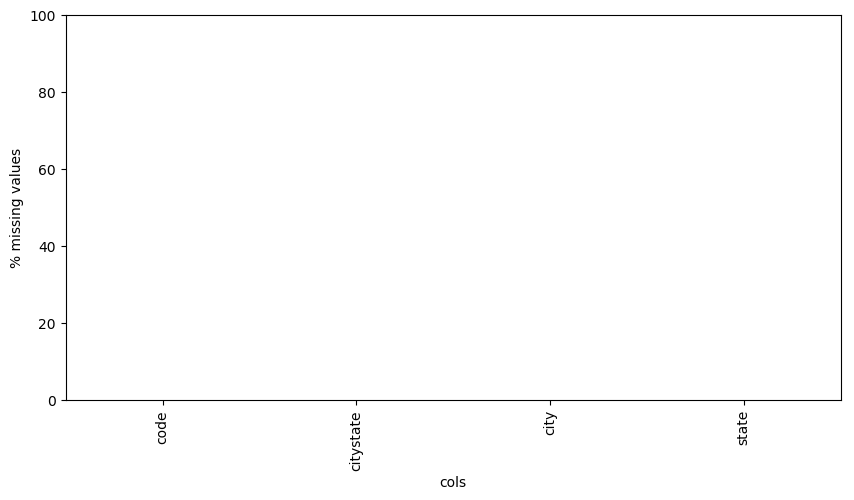

In [155]:
# lets visualize % missing values per immigration feature
visualize_missing_values(PoE_df1)

#### Airport Code data cleaning steps

#### Quality : airport_codes_df

- Keeping only US International airports serving passenger flights with immigration.
    - Keep only US Airports
    - Eliminate rows with NULL IATA codes
    - Keep only airport types small_airport, medium_airport, and large_airport
    - Remove rows having 'Duplicate' in airport name
    
#### Tidiness

- Structure changes to the airport dateframe
    - Drop unused columns continent, gps_code, ident
    - Split geo-coordinates into seperate columns
    - Extract region code from iso_region

***airport_codes_df1: Only keeping US airports serving passenger flights with immigration.***

***Define***

Process to eliminate Non-US airports from the dateframe.

- Keep only US airports
- Correct wrong continent value
- Eliminate rows which have NULL iata_code
- Keep only airport type small_airport, medium_airport and large_airport
- Remove rows with 'Duplicate' in airport name

Structure changes to the airport code dataframe

- Drop unused columns continent, gps_code and ident
- Split coordinates into seperate columns
- Extract region coded from iso_region

***Code***

In [156]:
%%time
# Dropping columns gps_code, ident
drop_cols = ['continent', 'gps_code', 'ident']
airport_codes_df1.drop(drop_cols, inplace = True, axis = 1)

#Keep only US Airports
airport_codes_df1 = airport_codes_df1[airport_codes_df1.iso_country =='US'].copy()

# Eliminate rows which has iata code as null
airport_codes_df1 = airport_codes_df1[~airport_codes_df1.iata_code.isnull()].copy()

# Keep only airport which is of type small_airport, medium_airport & large_airport
temp = ['small_airport', 'medium_airport', 'large_airport']
airport_codes_df1 = airport_codes_df1[airport_codes_df1['type'].isin(temp)].copy()

# Split coordinates into separate columns
airport_codes_df1[['longitude','latitude']] = airport_codes_df1.coordinates.str.split(", ",expand=True)

# Extract state code from iso_region
airport_codes_df1['state'] = airport_codes_df1.iso_region.str.slice(start=3)
    
# Removing rows having 'Duplicate' in airport names
airport_codes_df1 = airport_codes_df1[~airport_codes_df1.name.str.contains('uplicate')]

CPU times: user 40.5 ms, sys: 0 ns, total: 40.5 ms
Wall time: 40.9 ms


***Test***

In [157]:
print('Before : ',airport_codes_df.shape[0])
print('After  : ',airport_codes_df1.shape[0])

Before :  55075
After  :  1865


In [158]:
# Checks, regions are states
print('Total states columns that has null values = ',airport_codes_df1[airport_codes_df1.state.isnull()].shape[0])
print('Total states has string length = 2 : ',airport_codes_df1[airport_codes_df1.state.str.len() == 2].shape[0])

Total states columns that has null values =  0
Total states has string length = 2 :  1865


In [159]:
airport_codes_df1.head()

,type,name,elevation_ft,iso_country,iso_region,municipality,iata_code,local_code,coordinates,longitude,latitude,state
440,small_airport,Ocean Reef Club Airport,8.0,US,US-FL,Key Largo,OCA,07FA,"-80.274803161621, 25.325399398804",-80.274803161621,25.325399398804,FL
594,small_airport,Pilot Station Airport,305.0,US,US-AK,Pilot Station,PQS,0AK,"-162.899994, 61.934601",-162.899994,61.934601,AK
673,small_airport,Crested Butte Airpark,8980.0,US,US-CO,Crested Butte,CSE,0CO2,"-106.928341, 38.851918",-106.928341,38.851918,CO
1088,small_airport,LBJ Ranch Airport,1515.0,US,US-TX,Johnson City,JCY,0TE7,"-98.62249755859999, 30.251800537100003",-98.62249755859999,30.251800537100003,TX
1402,small_airport,Metropolitan Airport,418.0,US,US-MA,Palmer,PMX,13MA,"-72.31140136719999, 42.223300933800004",-72.31140136719999,42.223300933800004,MA


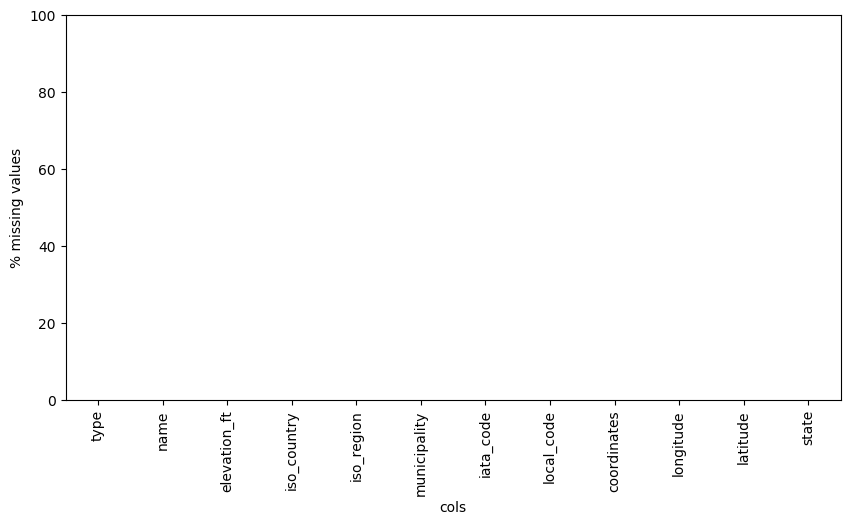

In [160]:
# lets visualize % missing values per immigration feature
visualize_missing_values(airport_codes_df1)

#### US Demographics data cleaning steps

***Quality***
- demographics_df : Updating city names as some don't match up with df_uszips
- demographics_df : Deleting rows which has Male & Female population as 0    
     
***Tideness***

- demographics_df : Below structure changes will be carried out in demographic dataframe
     a) Convert floats to ints for columns 'Male Population', 'Female Population', 'Number of Veterans', 'Foreign-born', 'Total Population', 'Count'
     b) Unmelting the race rows values to separate columns   

#### Quality : demographics_df

- Did find any quality issues
    
#### Tidiness

- Structure changes to the demographics dateframe
    - Convert floats to ints for columns Male Population, Female Population, Number of Veterans, Foreign-born, Total Population, Count
    - Split main demographics table into 2 tables
        - population
        - race
    - unmelting to convert Race rows to columns

In [161]:
# Convert floats to ints
cols_to_convert_float_to_int = ['Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Count']

for col in cols_to_convert_float_to_int:
    demographics_df1[col] = demographics_df1[col].replace(np.nan, 0)
    demographics_df1[col] = demographics_df1[col].astype(int)

# Split based on Population
demog_df = demographics_df1[['State', 'City', 'Median Age', 'State Code', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born']]
demog_df = demog_df.drop_duplicates()    

# Split based on Race
race_df = demographics_df1[['State', 'City', 'Race', 'Count']].copy()

# Summing up the duplicates
race_df = race_df.groupby(['State', 'City', 'Race']).sum().reset_index().copy()

# Unmelting to converts Race rows to columns
race_df = race_df.set_index(['State','City', 'Race']).Count.unstack().reset_index()
race_df.columns.name = None
race_df[race_df.State =='Alabama'].head()

# Convert floats to ints
cols_to_convert_float_to_int = ['American Indian and Alaska Native','Asian', 'Black or African-American', 'Hispanic or Latino', 'White']

for col in cols_to_convert_float_to_int:
    race_df[col] = race_df[col].replace(np.nan, 0)
    race_df[col] = race_df[col].astype(int)
    
# Rename column names
race_df.rename(columns={"American Indian and Alaska Native": "American_Indian_and_Alaska_Native"
                        , "Black or African-American":"Black_or_African_American"
                        , "Hispanic or Latino":"Hispanic_or_Latino"}, inplace=True)

demog_df.rename(columns={"Median Age": "Median_Age" , "State Code":"State_Code", "Male Population":"Male_Population"
                         , "Female Population":"Female_Population", "Total Population":"Total_Population" 
                         , "Number of Veterans":"Number_of_Veterans", "Foreign-born" : "Foreign_born"}, inplace=True)

***Test***

In [162]:
print('race_df = ',race_df.shape[0])

race_df =  596


In [163]:
race_df.head()

,State,City,American_Indian_and_Alaska_Native,Asian,Black_or_African_American,Hispanic_or_Latino,White
0,Alabama,Birmingham,1319,1500,157985,8940,51728
1,Alabama,Dothan,656,1175,23243,1704,43516
2,Alabama,Hoover,0,4759,18191,3430,61869
3,Alabama,Huntsville,1755,6566,61561,10887,121904
4,Alabama,Mobile,2816,5518,96397,5229,93755


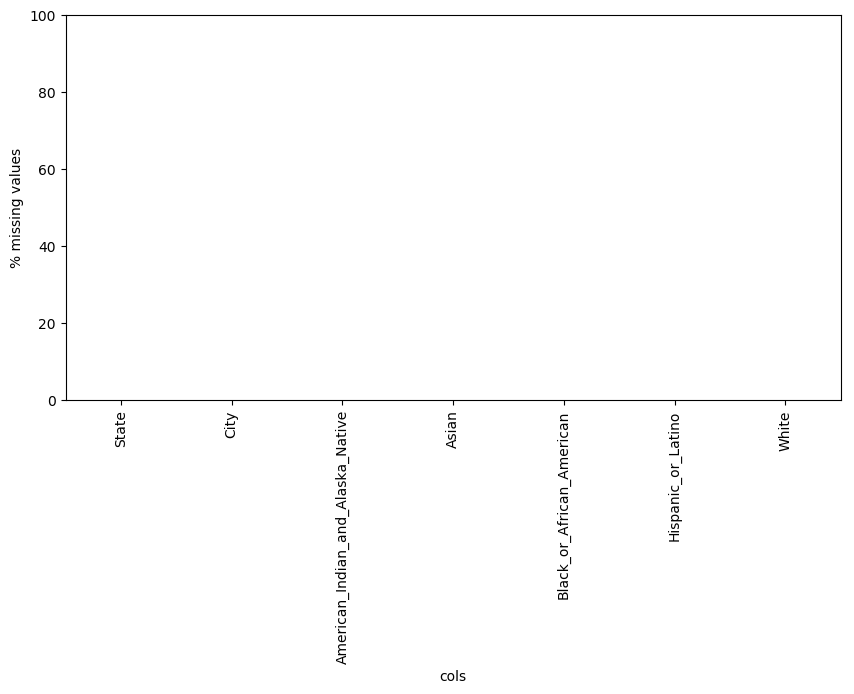

In [164]:
# lets visualize % missing values per immigration feature
visualize_missing_values(race_df)

In [165]:
print('demog_df = ',demog_df.shape[0])

demog_df =  596


In [166]:
demog_df.head()

,State,City,Median_Age,State_Code,Male_Population,Female_Population,Total_Population,Number_of_Veterans,Foreign_born
0,Maryland,Silver Spring,33.8,MD,40601,41862,82463,1562,30908
1,Massachusetts,Quincy,41.0,MA,44129,49500,93629,4147,32935
2,Alabama,Hoover,38.5,AL,38040,46799,84839,4819,8229
3,California,Rancho Cucamonga,34.5,CA,88127,87105,175232,5821,33878
4,New Jersey,Newark,34.6,NJ,138040,143873,281913,5829,86253


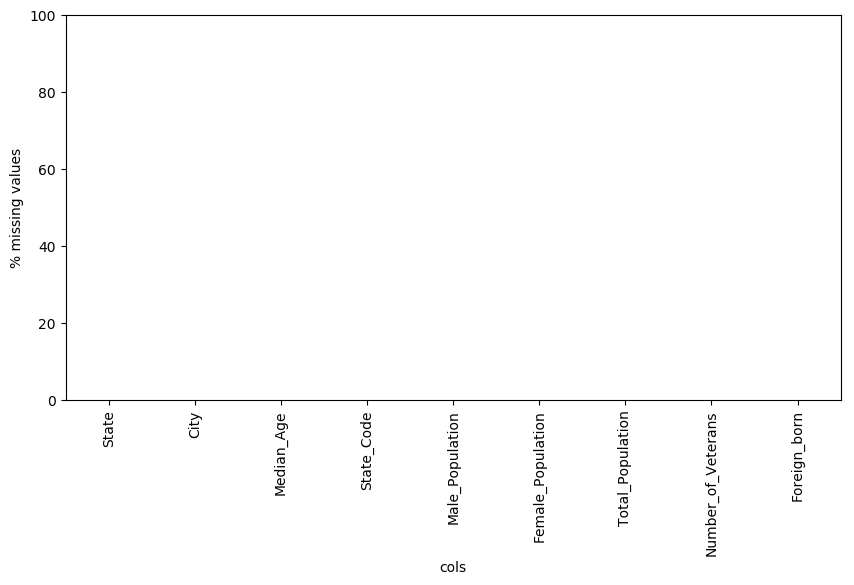

In [167]:
# lets visualize % missing values per immigration feature
visualize_missing_values(demog_df)

#### World Temperature data cleaning steps

***Quality***

- No quality issues found 
     
***Tideness***

- Convert dt to datetime from object
- drop columns AverageTemperatureUncertainty, Latitude, Longitude
- remove missing temperatures
- elimiated any duplicates
- keep only US temperatures

***Code***

In [168]:
# Keeping only US temperatures
worldtemp_df1 = worldtemp_df1[worldtemp_df1.Country=='United States'].copy()

# Rounding temperature to decimals=3 
worldtemp_df1['AverageTemperature'] = worldtemp_df1['AverageTemperature'].round(decimals=3)

# Dropping unused columns
drop_cols = ['AverageTemperatureUncertainty', 'Latitude', 'Longitude']
worldtemp_df1.drop(drop_cols, inplace = True, axis = 1)

# Removing missing temperatures
worldtemp_df1 = worldtemp_df1[~(worldtemp_df1.AverageTemperature.isnull())]

# Eliminating the duplicates(ie., multiple locations in same city)
worldtemp_df1 = worldtemp_df1.drop_duplicates(['dt', 'City', 'Country'],keep= 'first')

# Convert dt to datetime from object
worldtemp_df1['dt'] = pd.to_datetime(worldtemp_df1.dt)

***Test***

In [169]:
worldtemp_df1.head()

,dt,AverageTemperature,City,Country
47555,1820-01-01,2.101,Abilene,United States
47556,1820-02-01,6.926,Abilene,United States
47557,1820-03-01,10.767,Abilene,United States
47558,1820-04-01,17.989,Abilene,United States
47559,1820-05-01,21.809,Abilene,United States


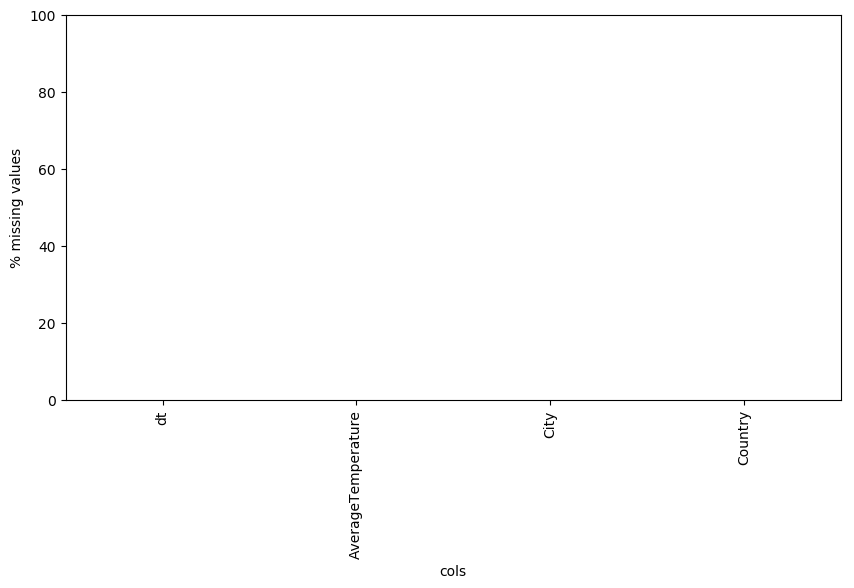

In [170]:
# lets visualize % missing values per immigration feature
visualize_missing_values(worldtemp_df1)

***Save clean Immigration dataset***

In [171]:
print("Cleaned datasets")
print("{} = {}".format("immigration_df1", immigration_df1.shape[0]))
print("{} = {}".format("PoE_df1", PoE_df1.shape[0]))
print("{} = {}".format("airport_codes_df1", airport_codes_df1.shape[0]))
print("{} = {}".format("demographics_df1", demographics_df1.shape[0]))
print("{} = {}".format("demog_df", demog_df.shape[0]))
print("{} = {}".format("race_df", race_df.shape[0]))
print("{} = {}".format("worldtemp_df1", worldtemp_df1.shape[0]))

Cleaned datasets
immigration_df1 = 792
PoE_df1 = 509
airport_codes_df1 = 1865
demographics_df1 = 2891
demog_df = 596
race_df = 596
worldtemp_df1 = 639649


In [172]:
# Cleaned datasets
immigration_df1.to_csv('outputs/immigration_df1.csv', encoding='utf-8', index=False)
PoE_df1.to_csv('outputs/PoE_df1.csv', encoding='utf-8', index=False)
airport_codes_df1.to_csv('outputs/airport_codes_df1.csv', encoding='utf-8', index=False)
demographics_df1.to_csv('outputs/demographics_df1.csv', encoding='utf-8', index=False)
demog_df.to_csv('outputs/demog_df.csv', encoding='utf-8', index=False)
race_df.to_csv('outputs/race_df.csv', encoding='utf-8', index=False)
worldtemp_df1.to_csv('outputs/worldtemp_df1.csv', encoding='utf-8', index=False)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

After gathering, reviewing, and cleaning all the datasets, it seems the i94 data will be the central data point.

1. There will be staging tables needed to preprocess the data before loading it into the data warehouse tables.  

    - staging_immigration_table
    
        - "CoC" VARCHAR,
        - "CoR" VARCHAR,
        - "PoE" VARCHAR,
        - "age" VARCHAR,
        - "arrival_state" VARCHAR,
        - "biryear" VARCHAR,
        - "gender" VARCHAR,
        - "airline" VARCHAR,
        - "admnum" VARCHAR,
        - "fltno" VARCHAR,
        - "visatype" VARCHAR,
        - "arrival_mode" VARCHAR,
        - "visit_purpose" VARCHAR,
        - "arrival_dt" TIMESTAMP,
        - "departure_dt" TIMESTAMP

    - staging_PoE_table
        - "code" VARCHAR,
        - "citystate" VARCHAR,
        - "city" VARCHAR,
        - "state" VARCHAR

    - staging_airport_codes
        - "type" VARCHAR,
        - "name" VARCHAR,
        - "elevation_ft" DECIMAL(16,5),
        - "iso_country" VARCHAR,
        - "iso_region" VARCHAR,
        - "municipality" VARCHAR,
        - "iata_code" VARCHAR,
        - "local_code" VARCHAR,
        - "coordinates" VARCHAR,
        - "longitude" VARCHAR,
        - "latitude" VARCHAR,
        - "state" VARCHAR

    - staging_demog_table(
        - "State" VARCHAR,
        - "City" VARCHAR,
        - "Median_Age" DECIMAL(16,5),
        - "State_Code" VARCHAR,
        - "Male_Population" INTEGER,
        - "Female_Population" INTEGER,
        - "Total_Population" INTEGER,
        - "Number_of_Veterans" INTEGER,
        - "Foreign_born" INTEGER

    - staging_race_table
        - "State" VARCHAR,
        - "City" VARCHAR,
        - "American_Indian_and_Alaska_Native" INTEGER,
        - "Asian" INTEGER,
        - "Black_or_African_American" INTEGER,
        - "Hispanic_or_Latino" INTEGER,
        - "White" INTEGER

    - staging_worldtemp_table
        - "dt" TIMESTAMP,
        - "AverageTemperature" DECIMAL(16,5),
        - "City" VARCHAR,
        - "Country" VARCHAR

2. The data warehouse tables will be where the main fact and dimension tables will be created and loaded.

    - fact_immigration_table
        - "CoC" VARCHAR,
        - "CoR" VARCHAR,
        - "PoE" VARCHAR,
        - "age" VARCHAR,
        - "arrival_state" VARCHAR,
        - "biryear" VARCHAR,
        - "gender" VARCHAR,
        - "airline" VARCHAR,
        - "admnum" VARCHAR,
        - "fltno" VARCHAR,
        - "visatype" VARCHAR,
        - "arrival_mode" VARCHAR,
        - "visit_purpose" VARCHAR,
        - "arrival_dt" TIMESTAMP,
        - "departure_dt" TIMESTAMP,
        - CONSTRAINT fact_immigration_pk PRIMARY KEY ("age", "arrival_dt", "CoR")

    - dim_airport_codes_table
        - "type" VARCHAR,
        - "name" VARCHAR,
        - "elevation_ft" DECIMAL(16,5),
        - "iso_country" VARCHAR,
        - "iso_region" VARCHAR,
        - "municipality" VARCHAR,
        - "iata_code" VARCHAR,
        - "local_code" VARCHAR,
        - "coordinates" VARCHAR,
        - "longitude" VARCHAR,
        - "latitude" VARCHAR,
        - "state" VARCHAR,
        - CONSTRAINT dim_airport_codes_pk PRIMARY KEY ("type", "name")

    - dim_PoE_table
        - "code" VARCHAR,
        - "citystate" VARCHAR,
        - "city" VARCHAR,
        - "state" VARCHAR,
        - CONSTRAINT dim_PoE_pk PRIMARY KEY ("code")

    - dim_demog_table
        - "State" VARCHAR,
        - "City" VARCHAR,
        - "Median_Age" DECIMAL(16,5),
        - "State_Code" VARCHAR,
        - "Male_Population" INTEGER,
        - "Female_Population" INTEGER,
        - "Total_Population" INTEGER,
        - "Number_of_Veterans" INTEGER,
        - "Foreign_born" INTEGER,
        - CONSTRAINT dim_demog_pk PRIMARY KEY ("State", "City")

    - dim_race_table
        - "State" VARCHAR,
        - "City" VARCHAR,
        - "American_Indian_and_Alaska_Native" INTEGER,
        - "Asian" INTEGER,
        - "Black_or_African_American" INTEGER,
        - "Hispanic_or_Latino" INTEGER,
        - "White" INTEGER,
        - CONSTRAINT dim_race_pk PRIMARY KEY ("State", "City")
    
    - dim_worldtemp_table
        - "dt" TIMESTAMP,
        - "AverageTemperature" DECIMAL(16,5),
        - "City" VARCHAR,
        - "Country" VARCHAR,
        - CONSTRAINT dim_worldtemp_pk PRIMARY KEY ("dt", "City", "Country")

#### 3.2 Mapping Out Data Pipelines

There much consideration put into the process of validating missing data, ensuring quality data, and determining where dirty data was so it could be discarded.  

All data quality issues and tidiness issues are identified clearly in Step 2: Explore and Assess the Data.  

Steps followed were:

- import libraries
- load configurations
- create spark session
- load datasets
- explore and assess datasets
- clean datasets
- save cleaned datasets to S3
- create dimension and fact tables
- load data into tables

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model

The data model is built in the etl.py file and the data dictionaries are in the data_dictionary folder.  The data model and data dictionaries will be displayed in the readme.md file.

Below are the Fact and Dimension Tables used for this project:

***Fact Table***
- *fact_immigration*: Contains details on travelers entering the US.

***Dimension Tables***
- *dim_airport_codes*: This table contains information on US airports.
- *dim_PoE*: This is a reference table containing information on US Port of Entry codes, city and state names.
- *dim_demog*: This table contains information on population details in city and states.
- *dim_race*: This table contains information on various races in city and states.
- *dim_worldtemp*: This table contains information on temperatures globally with city and country.

#### 4.2 Data Quality Checks

In the Capstone Project Submission.ipynb file the date quality checkes were performed 
 
Run Quality Checks code is below.

In [173]:
def count_rows(cur, conn):
    """
    Get the number of rows stored into each table
  
    Parameters: 
    arg1 : cursor connection object on redshift
    arg2 : connection object on the redshift
  
    Returns: 
    None
    """    
    print('line 328')
    print('\r{:5}* {}'.format('',schema_queries[2]['message']))    
    cur.execute(schema_queries[2]['query'])
    
    for o in count_rows_queries:
        print('\r{:5}* {}'.format('',o['message']))    
        cur.execute(o['query'])
        print('query')
        #results = cur.fetchone()
        results = cur.fetchall()

        for row in results:
            if(len(row) == 1):
                print('{:8} {}'.format(' ', row[0]))
                print('line 342')
            else:
                print('{:8} {} - {}'.format(' ', row[0], row[1]))
                print('line 345')
            #print("   ", type(row), row)

def count_rows_staging(cur, conn, fname):
    """
    Get the number of rows stored into each table
  
    Parameters: 
    arg1 : cursor connection object on redshift
    arg2 : connection object on the redshift
  
    Returns: 
    None
    """    
    print('line 359')
    
    table_data = json.load(open(fname))
    for table, data in table_data.items():
        print('line 365')
        sql_stmt = 'SELECT COUNT(*) FROM {}'.format(table)
        try:
            cur.execute(sql_stmt)
            results = cur.fetchall()
            print('line 371')
            for row in results:
                #print("   ", type(row), row)                            
                if(len(row) == 1):
                    print('{:8} {:25} - {}'.format(' ', table, row[0]))
                    print('line376')
        except psycopg2.Error as e:
            print(e)
            conn.close()        

#### 4.3 Data dictionary 

There are data quality checks completed during the project.  During the etl.py the counts validate data was inserted into the tables. 

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.